# Предсказание отклика клиента на промо банка

# Задача

Один из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение.

Задача заключается в том, чтобы предложить алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.

# Описание таблиц с данными

**D_work**

Описание статусов относительно работы:
- ID — идентификатор социального статуса клиента относительно работы;
- COMMENT — расшифровка статуса.


**D_pens**

Описание статусов относительно пенсии:
- ID — идентификатор социального статуса;
- COMMENT — расшифровка статуса.


**D_clients**

Описание данных клиентов:
- ID — идентификатор записи;
- AGE	— возраст клиента;
- GENDER — пол клиента (1 — мужчина, 0 — женщина);
- EDUCATION — образование;
- MARITAL_STATUS — семейное положение;
- CHILD_TOTAL	— количество детей клиента;
- DEPENDANTS — количество иждивенцев клиента;
- SOCSTATUS_WORK_FL	— социальный статус клиента относительно работы (1 — работает, 0 — не работает);
- SOCSTATUS_PENS_FL	— социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);
- REG_ADDRESS_PROVINCE — область регистрации клиента;
- FACT_ADDRESS_PROVINCE — область фактического пребывания клиента;
- POSTAL_ADDRESS_PROVINCE — почтовый адрес области;
- FL_PRESENCE_FL — наличие в собственности квартиры (1 — есть, 0 — нет);
- OWN_AUTO — количество автомобилей в собственности.


**D_agreement**

Таблица с зафиксированными откликами клиентов на предложения банка:
- AGREEMENT_RK — уникальный идентификатор объекта в выборке;
- ID_CLIENT — идентификатор клиента;
- TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было).
    
    
**D_job**

Описание информации о работе клиентов:
- GEN_INDUSTRY — отрасль работы клиента;
- GEN_TITLE — должность;
- JOB_DIR — направление деятельности внутри компании;
- WORK_TIME — время работы на текущем месте (в месяцах);
- ID_CLIENT — идентификатор клиента.


**D_salary**

Описание информации о заработной плате клиентов:
- ID_CLIENT — идентификатор клиента;
- FAMILY_INCOME — семейный доход (несколько категорий);
- PERSONAL_INCOME — личный доход клиента (в рублях).


**D_last_credit**

Информация о последнем займе клиента:
- ID_CLIENT — идентификатор клиента;
- CREDIT — сумма последнего кредита клиента (в рублях);
- TERM — срок кредита;
- FST_PAYMENT — первоначальный взнос (в рублях).


**D_loan**

Информация о кредитной истории клиента:
- ID_CLIENT — идентификатор клиента;
- ID_LOAN — идентификатор кредита.

**D_close_loan**

Информация о статусах кредита (ссуд):
- ID_LOAN — идентификатор кредита;
- CLOSED_FL — текущий статус кредита (1 — закрыт, 0 — не закрыт).

# 1 Загрузка библиотек

In [ ]:
# Загрузка необходимых пакетов
!pip install catboost
!pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
# Установка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm import tqdm

import phik
from phik.report import plot_correlation_matrix
from phik import report
import altair as alt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
    BaggingClassifier,
)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    chi2,
    mutual_info_classif,
)
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import pickle
import _pickle as cPickle

from datetime import datetime
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

np.random.seed(42)

# 2 Загрузка данных

In [ ]:
# Подключим гугл диск
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Обозначим полный путь до *.csv файлов
DATA_PATH = "/content/drive/MyDrive/HSE ML&HLS/ММОВС23/1 - курс/5 - Прикладной Python/1-hw-streamlit/datasets/"

In [ ]:
# Подгрузим все файлы
d_clients = pd.read_csv(DATA_PATH + "D_clients.csv")
d_close_loan = pd.read_csv(DATA_PATH + "D_close_loan.csv")
d_job = pd.read_csv(DATA_PATH + "D_job.csv")
d_last_credit = pd.read_csv(DATA_PATH + "D_last_credit.csv")
d_loan = pd.read_csv(DATA_PATH + "D_loan.csv")
d_pens = pd.read_csv(DATA_PATH + "D_pens.csv")
d_salary = pd.read_csv(DATA_PATH + "D_salary.csv")
d_target = pd.read_csv(DATA_PATH + "D_target.csv")
d_work = pd.read_csv(DATA_PATH + "D_work.csv")

# 3 Исследовательский анализ данных

Посмотрим на загруженные таблицы:

In [ ]:
# Список всех таблиц
data_frames = [
    d_clients,
    d_close_loan,
    d_job,
    d_last_credit,
    d_loan,
    d_pens,
    d_salary,
    d_target,
    d_work,
]

# Названия всех таблиц
data_frames_names = [
    "d_clients - Данные клиентов",
    "d_close_loan - Информация о статусах кредита (ссуд)",
    "d_job - Описание информации о работе клиентов",
    "d_last_credit - Информация о последнем займе клиента",
    "d_loan - Информация о кредитной истории клиента",
    "d_pens - Описание статусов относительно пенсии",
    "d_salary - Описание информации о заработной плате клиентов",
    "d_target - Зафиксированные отклики клиентов на предложения банка",
    "d_work - Описание статусов относительно работы",
]

In [ ]:
# Вывод всех таблиц, по 3 строки в каждом
for name, df in zip(data_frames_names, data_frames):
    print(name)
    display(df.head(3))
    print()

d_clients - Данные клиентов


ID  AGE  GENDER            EDUCATION      MARITAL_STATUS  \
0  106805103   42       1              Среднее  Не состоял в браке   
1  106809308   28       1  Среднее специальное      Состою в браке   
2  106805867   64       0  Среднее специальное      Состою в браке   

   CHILD_TOTAL  DEPENDANTS  SOCSTATUS_WORK_FL  SOCSTATUS_PENS_FL  \
0            1           0                  1                  0   
1            1           1                  1                  0   
2            2           0                  1                  1   

  REG_ADDRESS_PROVINCE FACT_ADDRESS_PROVINCE POSTAL_ADDRESS_PROVINCE  \
0   Московская область    Московская область      Московская область   
1    Читинская область     Читинская область       Читинская область   
2    Иркутская область     Иркутская область       Иркутская область   

   FL_PRESENCE_FL  OWN_AUTO  
0               1         0  
1               0         0  
2               0         1


d_close_loan - Информация о статусах кредита (ссуд)


ID_LOAN  CLOSED_FL
0  1753790658          1
1  1753790659          1
2  1753790660          1


d_job - Описание информации о работе клиентов


GEN_INDUSTRY   GEN_TITLE                        JOB_DIR  \
0                   Торговля     Рабочий    Вспомогательный техперсонал   
1                   Торговля     Рабочий  Участие в основ. деятельности   
2  Информационные технологии  Специалист  Участие в основ. деятельности   

   WORK_TIME  ID_CLIENT  
0       18.0  106804370  
1       97.0  106804371  
2       84.0  106804372


d_last_credit - Информация о последнем займе клиента


CREDIT  TERM  FST_PAYMENT  ID_CLIENT
0   8000.0     6       8650.0  106804370
1  21650.0     6       4000.0  106804371
2  33126.0    12       4000.0  106804372


d_loan - Информация о кредитной истории клиента


ID_LOAN  ID_CLIENT
0  1753790658  106804370
1  1753790659  106804371
2  1753790660  106804372


d_pens - Описание статусов относительно пенсии


ID  FLAG       COMMENT
0   1     0     пенсионер
1   2     1  не пенсионер


d_salary - Описание информации о заработной плате клиентов


FAMILY_INCOME  PERSONAL_INCOME  ID_CLIENT
0  от 20000 до 50000 руб.          20000.0  106809321
1  от 20000 до 50000 руб.          14000.0  106815561
2  от 10000 до 20000 руб.          15000.0  106811521


d_target - Зафиксированные отклики клиентов на предложения банка


AGREEMENT_RK  ID_CLIENT  TARGET
0      59910150  106804370       0
1      59910230  106804371       0
2      59910525  106804372       0


d_work - Описание статусов относительно работы


ID  FLAG      COMMENT
0   1     0     работает
1   2     1  не работает
2   3     2  не известно

__Объединим всю инфорацию о клиентах в одну таблицу,  где одна строчка соответствует полной информации об одном клиенте__
 - Игнорируем таблицы `d_pens` и `d_work`, т.к присутствующая в них информация содержится в столбце `d_clients`.


In [ ]:
# Объединим таблицу d_loan (Информация о кредитной истории клиента) с таблицей d_close_loan (Информация о статусах кредита)
loan_merge_df = d_loan.merge(d_close_loan, on=["ID_LOAN"], how="left")

In [ ]:
# Объединим оставшиеся таблицы
df_full = (
    d_target.merge(loan_merge_df, on=["ID_CLIENT"], how="left")
    .merge(d_salary, on=["ID_CLIENT"], how="left")
    .merge(d_last_credit, on=["ID_CLIENT"], how="left")
    .merge(d_job, on=["ID_CLIENT"], how="left")
    .merge(d_clients, left_on="ID_CLIENT", right_on="ID", how="left")
)

# Отобразим получившуюся таблицу
pd.set_option("display.max_columns", None)
display(df_full.head(3))
df_full.shape

AGREEMENT_RK  ID_CLIENT  TARGET     ID_LOAN  CLOSED_FL  \
0      59910150  106804370       0  1753790658          1   
1      59910150  106804370       0  1753790658          1   
2      59910230  106804371       0  1753790659          1   

            FAMILY_INCOME  PERSONAL_INCOME   CREDIT  TERM  FST_PAYMENT  \
0  от 10000 до 20000 руб.           5000.0   8000.0     6       8650.0   
1  от 10000 до 20000 руб.           5000.0   8000.0     6       8650.0   
2  от 10000 до 20000 руб.          12000.0  21650.0     6       4000.0   

  GEN_INDUSTRY GEN_TITLE                        JOB_DIR  WORK_TIME         ID  \
0     Торговля   Рабочий    Вспомогательный техперсонал       18.0  106804370   
1     Торговля   Рабочий    Вспомогательный техперсонал       18.0  106804370   
2     Торговля   Рабочий  Участие в основ. деятельности       97.0  106804371   

   AGE  GENDER            EDUCATION  MARITAL_STATUS  CHILD_TOTAL  DEPENDANTS  \
0   49       1  Среднее специальное  Состою в браке            2           1   
1   49       1  Среднее специальное  Состою в браке            2           1   
2   32       1              Среднее  Состою в браке            3           3   

   SOCSTATUS_WORK_FL  SOCSTATUS_PENS_FL  REG_ADDRESS_PROVINCE  \
0                  1                  0  Оренбургская область   
1                  1                  0  Оренбургская область   
2                  1                  0    Кабардино-Балкария   

  FACT_ADDRESS_PROVINCE POSTAL_ADDRESS_PROVINCE  FL_PRESENCE_FL  OWN_AUTO  
0  Оренбургская область    Оренбургская область               0         0  
1  Оренбургская область    Оренбургская область               0         0  
2    Кабардино-Балкария      Кабардино-Балкария               0         0

(21535, 28)

In [ ]:
# Словарь с переводом имени колонок
names_cols_dict = {
    "AGREEMENT_RK": "AGREEMENT_RK - уникальный идентификатор объекта в выборке",
    "TARGET": "TARGET - целевая переменная",
    "CLOSED_FL": "CLOSED_FL - текущий статус кредита",
    "FAMILY_INCOME": "FAMILY_INCOME - семейный доход",
    "PERSONAL_INCOME": "PERSONAL_INCOME - личный доход",
    "CREDIT": "CREDIT - сумма последнего кредита клиента",
    "TERM": "TERM - срок кредита",
    "FST_PAYMENT": "FST_PAYMENT - первоначальный взнос",
    "GEN_INDUSTRY": "GEN_INDUSTRY - отрасль работы клиента",
    "GEN_TITLE": "GEN_TITLE - должность",
    "JOB_DIR": "JOB_DIR - направление деятельности внутри компании",
    "WORK_TIME": "WORK_TIME - время работы на текущем месте, мес.",
    "AGE": "AGE - возраст клиента",
    "GENDER": "GENDER - пол клиента",
    "EDUCATION": "EDUCATION - образование",
    "MARITAL_STATUS": "MARITAL_STATUS - семейное положение",
    "CHILD_TOTAL": "CHILD_TOTAL - количество детей клиента",
    "DEPENDANTS": "DEPENDANTS - количество иждивенцев клиента",
    "SOCSTATUS_WORK_FL": "SOCSTATUS_WORK_FL - социальный статус клиента относительно работы",
    "SOCSTATUS_PENS_FL": "SOCSTATUS_PENS_FL - социальный статус клиента относительно пенсии",
    "REG_ADDRESS_PROVINCE": "REG_ADDRESS_PROVINCE - область регистрации клиента",
    "FACT_ADDRESS_PROVINCE": "FACT_ADDRESS_PROVINCE - область фактического пребывания клиента",
    "POSTAL_ADDRESS_PROVINCE": "POSTAL_ADDRESS_PROVINCE - почтовый адрес области",
    "FL_PRESENCE_FL": "FL_PRESENCE_FL - наличие в собственности квартиры",
    "OWN_AUTO": "OWN_AUTO - количество автомобилей в собственности",
}

__Дубликаты__

In [ ]:
# Удалим все дубликаты по `ID_CLIENT`
df_full = (
    df_full[~df_full.duplicated(subset=["ID_CLIENT"], keep="first")]
    .reset_index(drop=True)
    .copy()
)
df_full.shape

(15223, 28)

__Сформируем таблицу с итоговыми столбцами__

In [ ]:
# Удалим лишние столбцы такие как `ID_CLIENT`, `ID_LOAN`, `ID`
df_full = df_full.drop(labels=["ID_CLIENT", "ID_LOAN", "ID"], axis=1).copy()

### 3.1 Исследование числовых переменных

In [ ]:
# Определим числовые переменные
numerical = [var for var in df_full.columns if df_full[var].dtype != "O"]

print("There are {} numerical variables\n".format(len(numerical)))
print("The numerical variables are :", numerical)

There are 16 numerical variables

The numerical variables are : ['AGREEMENT_RK', 'TARGET', 'CLOSED_FL', 'PERSONAL_INCOME', 'CREDIT', 'TERM', 'FST_PAYMENT', 'WORK_TIME', 'AGE', 'GENDER', 'CHILD_TOTAL', 'DEPENDANTS', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'FL_PRESENCE_FL', 'OWN_AUTO']


In [ ]:
# Количество уникальных значений
df_full[numerical].nunique()

AGREEMENT_RK         15223
TARGET                   2
CLOSED_FL                2
PERSONAL_INCOME        274
CREDIT                8029
TERM                    22
FST_PAYMENT           2937
WORK_TIME              302
AGE                     47
GENDER                   2
CHILD_TOTAL             10
DEPENDANTS               8
SOCSTATUS_WORK_FL        2
SOCSTATUS_PENS_FL        2
FL_PRESENCE_FL           2
OWN_AUTO                 3
dtype: int64

In [ ]:
# Основные статистики
df_full[numerical].describe()

AGREEMENT_RK        TARGET     CLOSED_FL  PERSONAL_INCOME  \
count  1.522300e+04  15223.000000  15223.000000     15223.000000   
mean   6.540183e+07      0.119030      0.438613     13853.836323   
std    4.568181e+06      0.323835      0.496234      9015.467617   
min    5.991015e+07      0.000000      0.000000        24.000000   
25%    6.192092e+07      0.000000      0.000000      8000.000000   
50%    6.437100e+07      0.000000      0.000000     12000.000000   
75%    6.708802e+07      0.000000      1.000000     17000.000000   
max    7.529224e+07      1.000000      1.000000    250000.000000   

              CREDIT          TERM    FST_PAYMENT     WORK_TIME           AGE  \
count   15223.000000  15223.000000   15223.000000  1.385500e+04  15223.000000   
mean    14667.959345      8.101031    3398.562655  2.922120e+02     40.406096   
std     12147.873496      4.094090    5158.108934  2.436483e+04     11.601068   
min      2000.000000      3.000000       0.000000  1.000000e+00     21.000000   
25%      6500.000000      6.000000    1000.000000  2.400000e+01     30.000000   
50%     11550.000000      6.000000    2000.000000  4.800000e+01     39.000000   
75%     19170.000000     10.000000    4000.000000  1.100000e+02     50.000000   
max    119700.000000     36.000000  140000.000000  2.867959e+06     67.000000   

             GENDER   CHILD_TOTAL    DEPENDANTS  SOCSTATUS_WORK_FL  \
count  15223.000000  15223.000000  15223.000000       15223.000000   
mean       0.654536      1.099389      0.645208           0.909610   
std        0.475535      0.995411      0.812252           0.286748   
min        0.000000      0.000000      0.000000           0.000000   
25%        0.000000      0.000000      0.000000           1.000000   
50%        1.000000      1.000000      0.000000           1.000000   
75%        1.000000      2.000000      1.000000           1.000000   
max        1.000000     10.000000      7.000000           1.000000   

       SOCSTATUS_PENS_FL  FL_PRESENCE_FL      OWN_AUTO  
count       15223.000000    15223.000000  15223.000000  
mean            0.134468        0.309794      0.116337  
std             0.341165        0.462424      0.320844  
min             0.000000        0.000000      0.000000  
25%             0.000000        0.000000      0.000000  
50%             0.000000        0.000000      0.000000  
75%             0.000000        1.000000      0.000000  
max             1.000000        1.000000      2.000000

__Пропущенные значения__

In [ ]:
# Оценим долю пропущенных значений в стобцах числовых переменных
for col in numerical:
    if df_full[col].isnull().mean() > 0:
        prop_miss = round(df_full[col].isnull().mean(), 4)
        print(f"Пропуски в столбце: {col}. Доля пропущенных значений: {prop_miss}")

Пропуски в столбце: WORK_TIME. Доля пропущенных значений: 0.0899


__Выбросы__

Используем 0.75 квантиль + 1,5xIQR для отображения выбросов

In [ ]:
# Столбцы которые не рассматриваем на выбросы
not_consid_cols = [
    "AGREEMENT_RK",
    "TARGET",
    "CLOSED_FL",
    "GENDER",
    "SOCSTATUS_WORK_FL",
    "SOCSTATUS_PENS_FL",
    "FL_PRESENCE_FL",
]

In [ ]:
# Найдем выбросы в числовых переменных
for col in df_full[numerical].drop(labels=not_consid_cols, axis=1):
    # Верхний и нижний квантиль
    upper_q = df_full[col].quantile(0.75)
    lower_q = df_full[col].quantile(0.25)

    # Интерквантильный размах
    iqr = upper_q - lower_q

    # Пороговое значение выброса
    cut_off = iqr * 1.5

    # Нижняя и верхняя граница значения
    lower, upper = lower_q - cut_off, upper_q + cut_off

    # Нижняя граница не может быть меньше нуля
    if lower < 0:
        lower = 0

    upper_outliers = df_full[col][df_full[col] > upper].size / df_full[col].size * 100
    lower_outliers = df_full[col][df_full[col] < lower].size / df_full[col].size * 100
    print(
        "{col}: \n\
0.75 + 1,5xIQR: значение {upperboundary:.1f} - {upper_outliers:.3f}% от размера выборки".format(
            col=col, upperboundary=upper, upper_outliers=upper_outliers
        )
    )
    print(
        "0.25 + 1,5xIQR: значение {lowerboundary:.1f} - {lower_fence:.3f}% от размера выборки".format(
            col=col, lowerboundary=lower, lower_fence=lower_outliers
        )
    )
    print()

PERSONAL_INCOME: 
0.75 + 1,5xIQR: значение 30500.0 - 3.173% от размера выборки
0.25 + 1,5xIQR: значение 0.0 - 0.000% от размера выборки

CREDIT: 
0.75 + 1,5xIQR: значение 38175.0 - 3.593% от размера выборки
0.25 + 1,5xIQR: значение 0.0 - 0.000% от размера выборки

TERM: 
0.75 + 1,5xIQR: значение 16.0 - 3.252% от размера выборки
0.25 + 1,5xIQR: значение 0.0 - 0.000% от размера выборки

FST_PAYMENT: 
0.75 + 1,5xIQR: значение 8500.0 - 8.605% от размера выборки
0.25 + 1,5xIQR: значение 0.0 - 0.000% от размера выборки

WORK_TIME: 
0.75 + 1,5xIQR: значение 239.0 - 8.073% от размера выборки
0.25 + 1,5xIQR: значение 0.0 - 0.000% от размера выборки

AGE: 
0.75 + 1,5xIQR: значение 80.0 - 0.000% от размера выборки
0.25 + 1,5xIQR: значение 0.0 - 0.000% от размера выборки

CHILD_TOTAL: 
0.75 + 1,5xIQR: значение 5.0 - 0.138% от размера выборки
0.25 + 1,5xIQR: значение 0.0 - 0.000% от размера выборки

DEPENDANTS: 
0.75 + 1,5xIQR: значение 2.5 - 1.938% от размера выборки
0.25 + 1,5xIQR: значение 0.0 -

__Сводка по числовым переменным__

Всего определили 16 числовых пермеменных:
- 6 из которых являются категориальными бинарными пременными `TARGET`, `CLOSED_FL`, `GENDER`, `SOCSTATUS_WORK_FL`, `SOCSTATUS_PENS_FL` и `FL_PRESENCE_FL`;
- `TARGET` - целевая переменная;
- Пропущенные значения в столбце `WORK_TIME`;
- Доля выбросов не превышает 12% от размера выборки.

### 3.2 Исследование категориальных переменных

In [ ]:
# Определим категориальные переменные
categorical = [var for var in df_full.columns if df_full[var].dtype == "O"]

print("Всего {} категориальных переменных\n".format(len(categorical)))
print("Категориальные переменные:", categorical)

Всего 9 категориальных переменных

Категориальные переменные: ['FAMILY_INCOME', 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'EDUCATION', 'MARITAL_STATUS', 'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE']


In [ ]:
# Посмотрим на основные статистики
df_full[categorical].describe()

FAMILY_INCOME GEN_INDUSTRY   GEN_TITLE  \
count                    15223        13856       13856   
unique                       5           31          12   
top     от 10000 до 20000 руб.     Торговля  Специалист   
freq                      7077         2385        7010   

                              JOB_DIR            EDUCATION  MARITAL_STATUS  \
count                           13856                15223           15223   
unique                             10                    7               5   
top     Участие в основ. деятельности  Среднее специальное  Состою в браке   
freq                            11452                 6518            9416   

       REG_ADDRESS_PROVINCE FACT_ADDRESS_PROVINCE POSTAL_ADDRESS_PROVINCE  
count                 15223                 15223                   15223  
unique                   81                    81                      80  
top      Краснодарский край    Краснодарский край      Краснодарский край  
freq                    674                   674                     674

In [ ]:
# Выведем уникальные значения
for col in df_full[categorical].columns:
    print(col)
    print(df_full[col].unique())
    print()

FAMILY_INCOME
['от 10000 до 20000 руб.' 'от 20000 до 50000 руб.' 'свыше 50000 руб.'
 'от 5000 до 10000 руб.' 'до 5000 руб.']

GEN_INDUSTRY
['Торговля' 'Информационные технологии' 'Образование'
 'Государственная служба' 'Другие сферы' 'Сельское хозяйство'
 'Здравоохранение' 'Металлургия/Промышленность/Машиностроение' nan
 'Коммунальное хоз-во/Дорожные службы' 'Строительство' 'Транспорт'
 'Банк/Финансы' 'Ресторанный бизнес/Общественное питание' 'Страхование'
 'Нефтегазовая промышленность' 'СМИ/Реклама/PR-агенства' 'Энергетика'
 'Салоны красоты и здоровья' 'ЧОП/Детективная д-ть'
 'Развлечения/Искусство' 'Наука' 'Химия/Парфюмерия/Фармацевтика'
 'Сборочные производства' 'Туризм'
 'Юридические услуги/нотариальные услуги' 'Маркетинг' 'Подбор персонала'
 'Информационные услуги' 'Недвижимость' 'Управляющая компания' 'Логистика']

GEN_TITLE
['Рабочий' 'Специалист' 'Руководитель среднего звена'
 'Руководитель высшего звена' 'Служащий' 'Работник сферы услуг'
 'Высококвалифиц. специалист' 'Индивиду

__Пропущенные значения__

In [ ]:
# Оценим долю пропущенных значений в стобцах числовых переменных
for col in categorical:
    if df_full[col].isnull().mean() > 0:
        prop_miss = round(df_full[col].isnull().mean(), 4)
        print(f"Пропуски в столбце: {col}. Доля пропущенных значений: {prop_miss}")

Пропуски в столбце: GEN_INDUSTRY. Доля пропущенных значений: 0.0898
Пропуски в столбце: GEN_TITLE. Доля пропущенных значений: 0.0898
Пропуски в столбце: JOB_DIR. Доля пропущенных значений: 0.0898


__Сводка по категориальным переменным__
- Имеются 9 категориальных переменных;
- Аномальных значений среди уникальных значений признаков не выявлено;
- Пропущенные значения в столбце `GEN_INDUSTRY`, `GEN_TITLE`, `JOB_DIR`.

# 4 Обработка признаков

__Переназначение типов столбцов__

In [ ]:
# Столбцы с дискретными категориальными переменными находящиеся в числовых переменных
object_cols = [
    "TARGET",
    "CLOSED_FL",
    "GENDER",
    "SOCSTATUS_WORK_FL",
    "SOCSTATUS_PENS_FL",
    "FL_PRESENCE_FL",
    "OWN_AUTO",
    "DEPENDANTS",
    "CHILD_TOTAL",
]

In [ ]:
# Изменим тип данных для столбцов с числовыми переменными
for col in df_full[numerical][object_cols]:
    df_full[col] = df_full[col].astype("object")

In [ ]:
# Переопределим числовые переменные
numerical = [var for var in df_full.columns if df_full[var].dtype != "O"]

print("Всего {} категориальных переменных\n".format(len(numerical)))
print("Категориальные переменные:", numerical)

Всего 7 категориальных переменных

Категориальные переменные: ['AGREEMENT_RK', 'PERSONAL_INCOME', 'CREDIT', 'TERM', 'FST_PAYMENT', 'WORK_TIME', 'AGE']


In [ ]:
# Переопределим категориальные переменные
categorical = [var for var in df_full.columns if df_full[var].dtype == "O"]

print("Всего {} категориальных переменных\n".format(len(categorical)))
print("Категориальные переменные:", categorical)

Всего 18 категориальных переменных

Категориальные переменные: ['TARGET', 'CLOSED_FL', 'FAMILY_INCOME', 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'GENDER', 'EDUCATION', 'MARITAL_STATUS', 'CHILD_TOTAL', 'DEPENDANTS', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'FL_PRESENCE_FL', 'OWN_AUTO']


__Пропущенные значения__

Как выяснили ранее, пропуски в столбце `WORK_TIME` с числовым типом данных соотносится по количеству с пропусками в стобцах `GEN_INDUSTRY`, `GEN_TITLE`, `JOB_DIR`, `WORK_TIME` с категориальными типами данных.

Проанализируем данные строки c предположением что клиент с пропусками в столбцах на пенсии.

In [ ]:
# Определим столбцы с пропусками по всей таблице
miss_cols = df_full.columns[df_full.isnull().any()].to_list()
print(f"Пропуски в столбцах: {miss_cols}")

Пропуски в столбцах: ['GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'WORK_TIME']


In [ ]:
# Пропусками в любом из выбранных столбцов
nan_cols = df_full[df_full[miss_cols].isnull().any(axis=1)]

print(
    f"Пропуски в столбцах 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'WORK_TIME'. Количество строк: {nan_cols.shape[0]}"
)

Пропуски в столбцах 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'WORK_TIME'. Количество строк: 1368


In [ ]:
# Пропуски в любом из выбранных столбцов с условием что клиент на пенсии
nan_pens_cols = df_full[
    (df_full[miss_cols].isnull().any(axis=1)) & (df_full["SOCSTATUS_PENS_FL"] == 1)
]
nan_pens_ids = nan_pens_cols.index

print(
    f"Пропуски в столбцах 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'WORK_TIME' и клиент на пенсии. Количество строк: {nan_pens_cols.shape[0]}"
)

Пропуски в столбцах 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'WORK_TIME' и клиент на пенсии. Количество строк: 1367


Действительно, пропуски в столбцах обусловленны значением `1` столбца `SOCSTATUS_PENS_FL`. Однако один клиент не пенсионер.

In [ ]:
# Пропуски в любом из выбранных столбцов с условием что клиент НЕ пенсионер
nan_worker_cols = df_full[
    (df_full[miss_cols].isnull().any(axis=1)) & (df_full["SOCSTATUS_PENS_FL"] == 0)
]
nan_worker_ids = nan_worker_cols.index

print(
    f"Пропуски в столбцах 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'WORK_TIME' и клиент работающий. Количество строк: {nan_worker_cols.shape[0]}"
)

Пропуски в столбцах 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'WORK_TIME' и клиент работающий. Количество строк: 1


Для пенсионеров заполним пропуски значением `not_defined` и `-1`. Для работающего клиента медианой/модой по столбцу таблицы.

In [ ]:
# Цикл по замене пропуском not defined/-1 для пенсионеров человека с пропусками
# nan_pens_ids
for col in df_full[miss_cols]:
    if df_full[col].dtype != "O":
        value = -1
        df_full.loc[nan_pens_ids, col] = df_full.loc[nan_pens_ids, col].fillna(value)
    else:
        value = "not defined"
        df_full.loc[nan_pens_ids, col] = df_full.loc[nan_pens_ids, col].fillna(value)

In [ ]:
# Цикл по замене пропуском модой/медианой для работающего человека с пропусками
# nan_worker_ids
for col in df_full[miss_cols]:
    if df_full[col].dtype != "O":
        col_median = df_full[col].median()
        df_full.loc[nan_worker_ids, col] = df_full.loc[nan_worker_ids, col].fillna(
            col_median
        )
    else:
        col_mode = df_full[col].mode()[0]
        df_full.loc[nan_worker_ids, col] = df_full.loc[nan_worker_ids, col].fillna(
            col_mode
        )

### 4.1 Обработка числовых переменных

In [ ]:
df_full[numerical].drop("AGREEMENT_RK", axis=1).describe()

PERSONAL_INCOME         CREDIT          TERM    FST_PAYMENT  \
count     15223.000000   15223.000000  15223.000000   15223.000000   
mean      13853.836323   14667.959345      8.101031    3398.562655   
std        9015.467617   12147.873496      4.094090    5158.108934   
min          24.000000    2000.000000      3.000000       0.000000   
25%        8000.000000    6500.000000      6.000000    1000.000000   
50%       12000.000000   11550.000000      6.000000    2000.000000   
75%       17000.000000   19170.000000     10.000000    4000.000000   
max      250000.000000  119700.000000     36.000000  140000.000000   

          WORK_TIME           AGE  
count  1.522300e+04  15223.000000  
mean   2.658655e+02     40.406096  
std    2.324438e+04     11.601068  
min   -1.000000e+00     21.000000  
25%    1.400000e+01     30.000000  
50%    4.000000e+01     39.000000  
75%    9.600000e+01     50.000000  
max    2.867959e+06     67.000000

__PERSONAL_INCOME - личный доход__

In [ ]:
# Вывод 5 объектов с наименьшим и наибольшим доходом
pd.concat(
    [
        df_full[["PERSONAL_INCOME", "FAMILY_INCOME"]]
        .sort_values(by="PERSONAL_INCOME")
        .head(5),
        df_full[["PERSONAL_INCOME", "FAMILY_INCOME"]]
        .sort_values(by="PERSONAL_INCOME")
        .tail(5),
    ]
)

PERSONAL_INCOME           FAMILY_INCOME
3491              24.0  от 20000 до 50000 руб.
9091            1950.0            до 5000 руб.
9842            2000.0  от 10000 до 20000 руб.
4081            2000.0  от 10000 до 20000 руб.
5222            2100.0  от 10000 до 20000 руб.
11374         160000.0  от 20000 до 50000 руб.
144           170000.0  от 20000 до 50000 руб.
6276          220000.0  от 20000 до 50000 руб.
2726          250000.0  от 20000 до 50000 руб.
7273          250000.0  от 20000 до 50000 руб.

- Аномально низким выглядит персональный доход в 24 рубля. Это может быть как ошибкой так и действительностью. Предположим что в данном случае допущена ошибки и заменим доход на медианное значение.
- Персональный доход выше дохода семьи может означать как ошибку во введении дохода, ошибку в выборе категории, так и то что семейный доход не учитывает персональный.


In [ ]:
# Замена аномально низкого значения медианным
df_full.loc[3491, "PERSONAL_INCOME"] = df_full["PERSONAL_INCOME"].median()

__WORK_TIME - время работы на текущем месте, мес.__

- Будем считать что допустимое время работы клиента на текущем месте: `возраст - стаж >= 16 лет`. Аномальные значения заменим медианой по столбцу.

In [ ]:
# Выведем размер аномальных значений по условию выше
worktime_out_ids = df_full[df_full["AGE"] - df_full["WORK_TIME"] / 12 < 16].index
worktime_out_ids.shape[0]

47

In [ ]:
# Заменим аномальные значения медианой
df_full.loc[worktime_out_ids, "WORK_TIME"] = df_full["WORK_TIME"].median()

## 4.2 Обработка категориальных переменных

Пропуски были удалены выше, см. [пункт 4 - Пропущенные значения](https://colab.research.google.com/drive/1VDJS35-Df7_6ApivwwGTtobnN65_10x3#scrollTo=Lo-ypB26sS2F)

# 5 Визуализация

## 5.1 Визуальный анализ числовых переменных

__Графики распределения числовых переменных__

Для отображения аномальных значений используем диапазон квантилей (0.996) и (0.75 + 1,5xIQR)

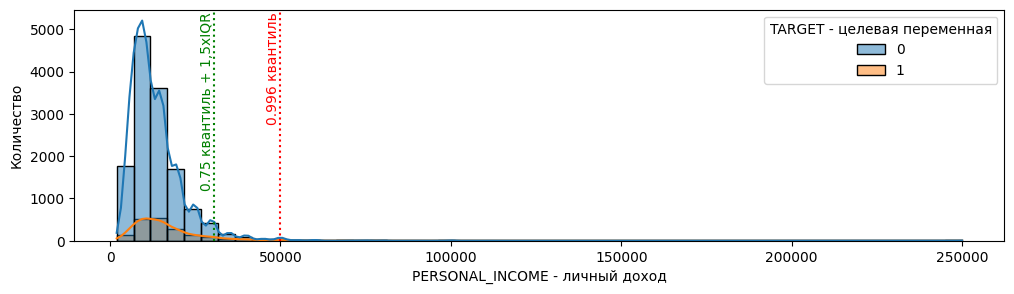

PERSONAL_INCOME: 
0.996 квантиль: значение 50000.0, кол-во выбросов: 56, доля: 0.0037
0.75 квантиль + 1,5xIQR: значение 30500.0, кол-во выбросов: 483, доля: 0.0317



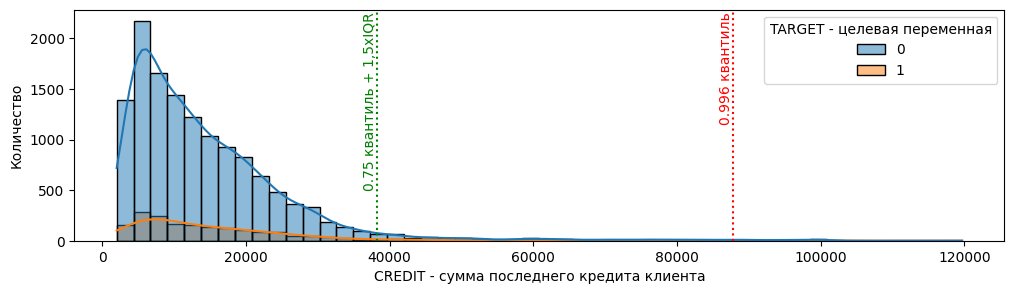

CREDIT: 
0.996 квантиль: значение 87796.5, кол-во выбросов: 61, доля: 0.0040
0.75 квантиль + 1,5xIQR: значение 38175.0, кол-во выбросов: 547, доля: 0.0359



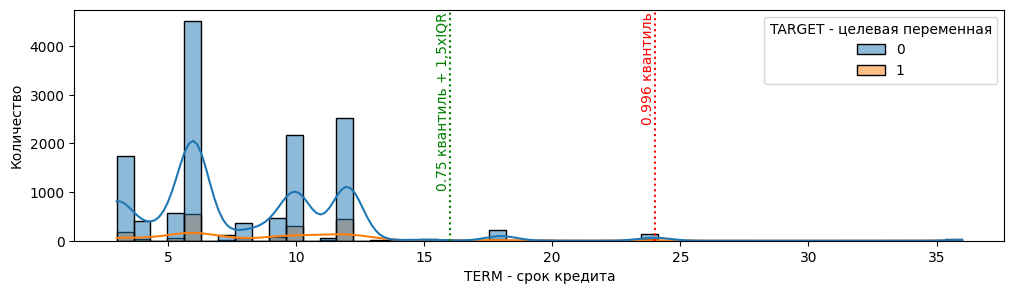

TERM: 
0.996 квантиль: значение 24.0, кол-во выбросов: 52, доля: 0.0034
0.75 квантиль + 1,5xIQR: значение 16.0, кол-во выбросов: 495, доля: 0.0325



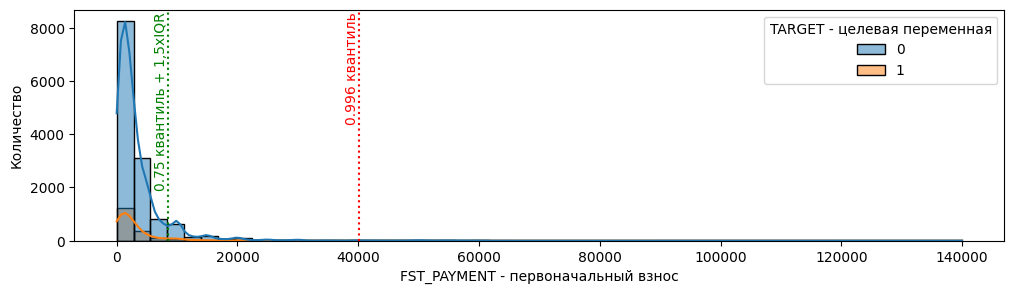

FST_PAYMENT: 
0.996 квантиль: значение 40163.2, кол-во выбросов: 61, доля: 0.0040
0.75 квантиль + 1,5xIQR: значение 8500.0, кол-во выбросов: 1310, доля: 0.0861



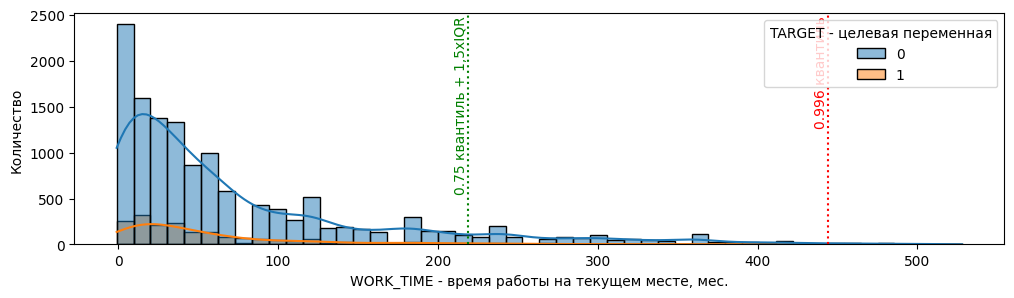

WORK_TIME: 
0.996 квантиль: значение 444.0, кол-во выбросов: 55, доля: 0.0036
0.75 квантиль + 1,5xIQR: значение 219.0, кол-во выбросов: 1295, доля: 0.0851



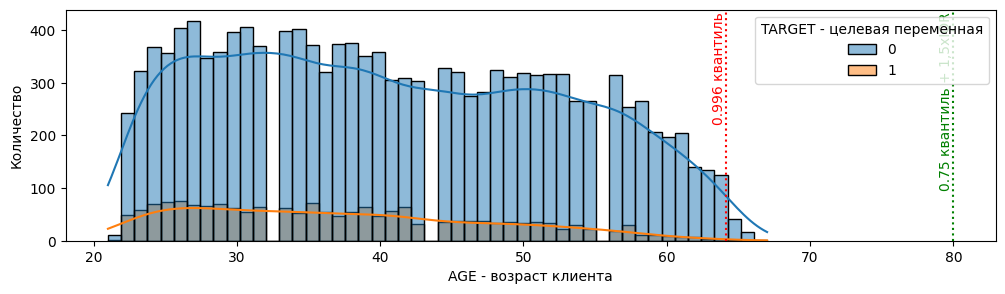

AGE: 
0.996 квантиль: значение 64.1, кол-во выбросов: 61, доля: 0.0040
0.75 квантиль + 1,5xIQR: значение 80.0, кол-во выбросов: 0, доля: 0.0000



In [ ]:
for column in df_full[numerical].drop("AGREEMENT_RK", axis=1):
    # Визуализация
    fig, ax = plt.subplots(figsize=(12, 3))
    fig = sns.histplot(data=df_full, x=column, hue="TARGET", bins=50, kde=True)
    sns.move_legend(ax, title=names_cols_dict["TARGET"], loc="best")

    ax.set_ylabel("Количество")
    ax.set_xlabel(names_cols_dict[column])

    # Граница по 0.966 квантилю
    upper_first = df_full[column].quantile(0.996)

    upper_outliers_size_first = df_full[column][df_full[column] > upper_first].size
    percent_first = upper_outliers_size_first / df_full[column].size

    ax.axvline(upper_first, color="r", linestyle=":")
    ax.text(
        upper_first,
        0.99,
        "0.996 квантиль",
        color="r",
        ha="right",
        va="top",
        rotation=90,
        transform=ax.get_xaxis_transform(),
    )

    # Граница по 0.75 + 1,5xIQR
    upper_q = df_full[column].quantile(0.75)
    lower_q = df_full[column].quantile(0.25)
    iqr = upper_q - lower_q
    cut_off = iqr * 1.5
    upper_second = upper_q + cut_off

    upper_outliers_size_second = df_full[column][df_full[column] > upper_second].size
    percent_second = upper_outliers_size_second / df_full[column].size

    ax.axvline(upper_second, color="g", linestyle=":")
    ax.text(
        upper_second,
        0.99,
        "0.75 квантиль + 1,5xIQR",
        color="g",
        ha="right",
        va="top",
        rotation=90,
        transform=ax.get_xaxis_transform(),
    )

    plt.show()
    print(
        f"{column}: \n\
0.996 квантиль: значение {upper_first:.1f}, кол-во выбросов: {upper_outliers_size_first}, доля: {percent_first:.4f}"
    )
    print(
        f"0.75 квантиль + 1,5xIQR: значение {upper_second:.1f}, кол-во выбросов: {upper_outliers_size_second}, доля: {percent_second:.4f}"
    )
    print()

[Kaggle - link](https://www.kaggle.com/code/akhiljethwa/playground-s4e1-eda-modeling-xgboost)

- Колонки кроме возраста - показывают асимметрию распределений, что обусловлено выбросами;
- Распределение данных для обоих классов целевой переменной, визуально, практически одинаково.

__Графики парных распределений__

In [ ]:
# Данные для визуализации
df_num_plt = df_full[
    ["PERSONAL_INCOME", "CREDIT", "TERM", "FST_PAYMENT", "WORK_TIME", "AGE", "TARGET"]
].copy()

In [ ]:
# Тип целевой переменной - числовой
df_num_plt["TARGET"] = df_num_plt["TARGET"].astype("int64")

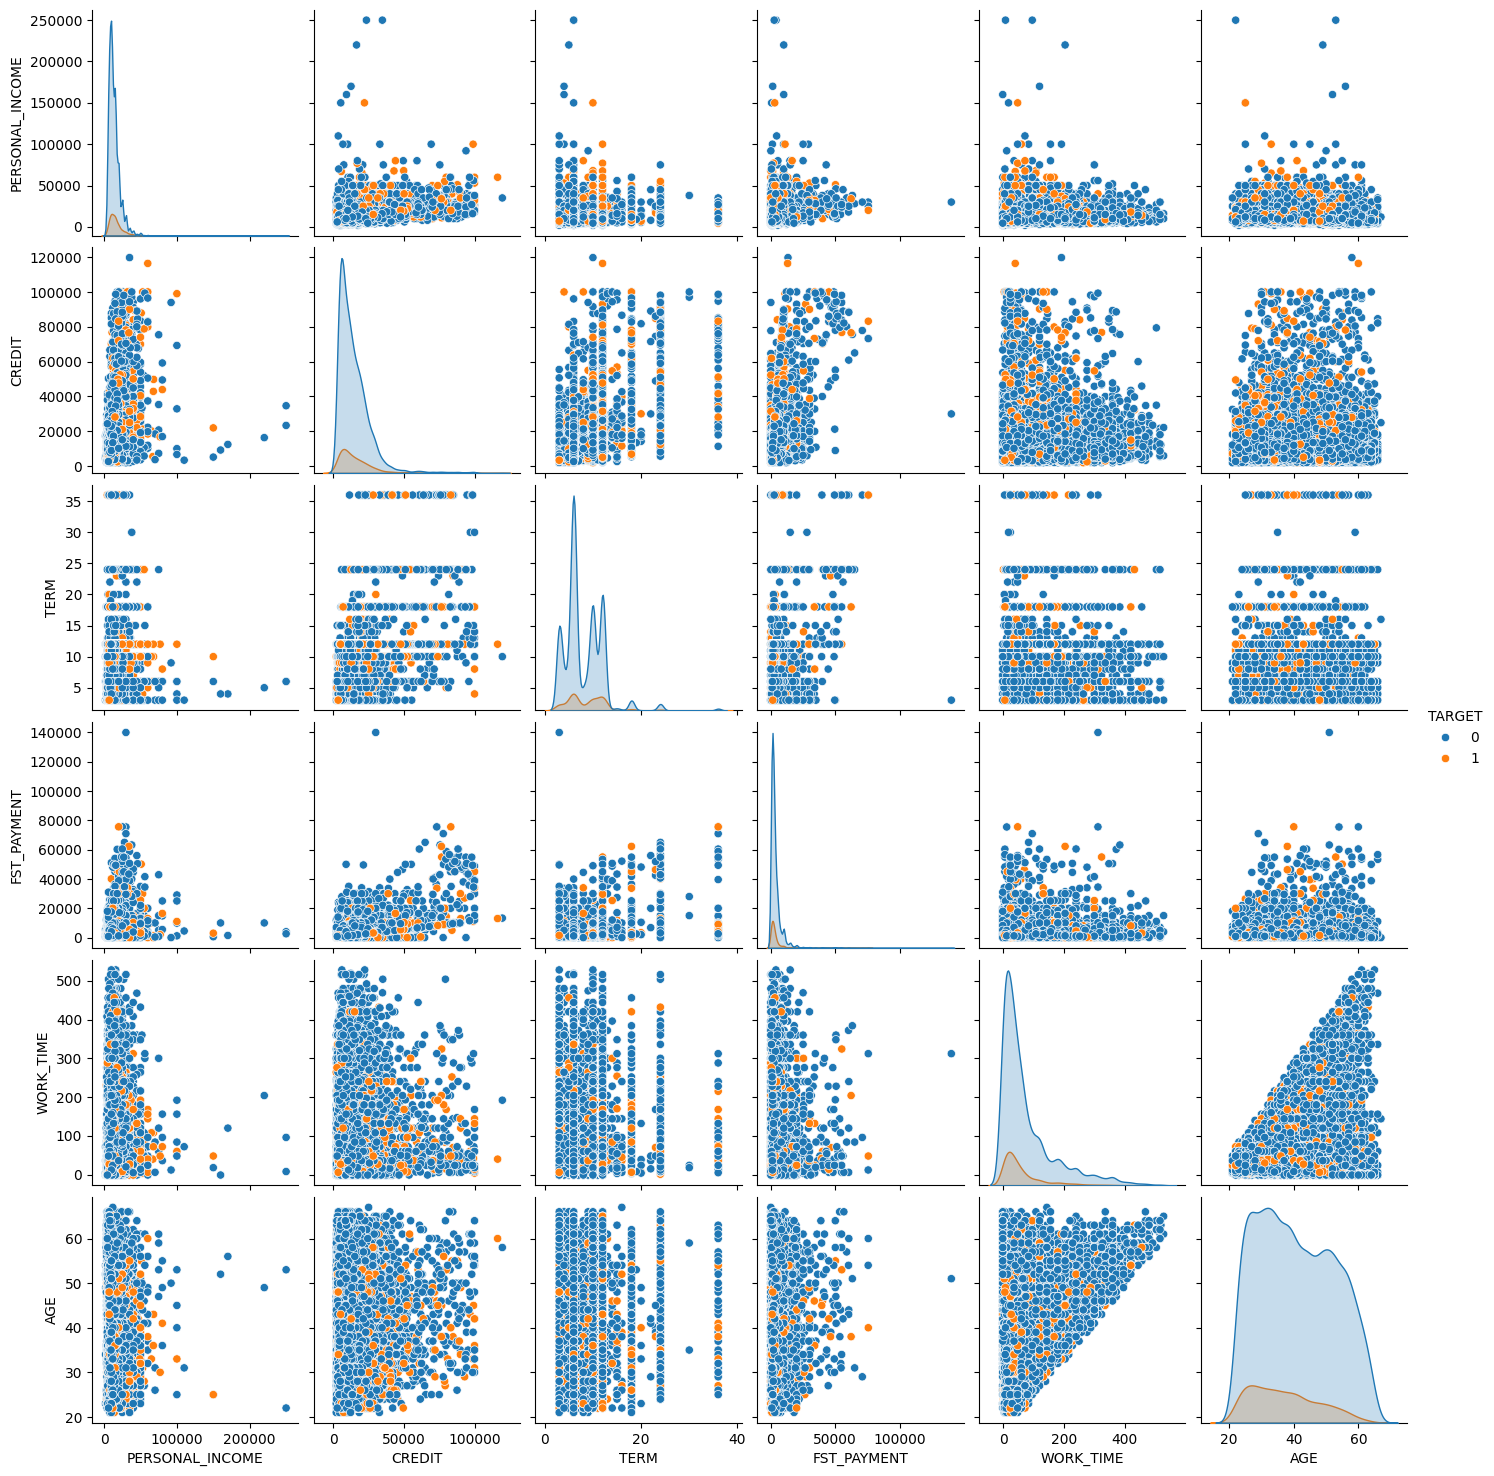

In [ ]:
# Визуализируем график парных распределений числовых признаков
g = sns.pairplot(data=df_num_plt, hue="TARGET")
g.fig.set_size_inches(15, 15)
plt.show()

__Тепловая карта парных корреляций__

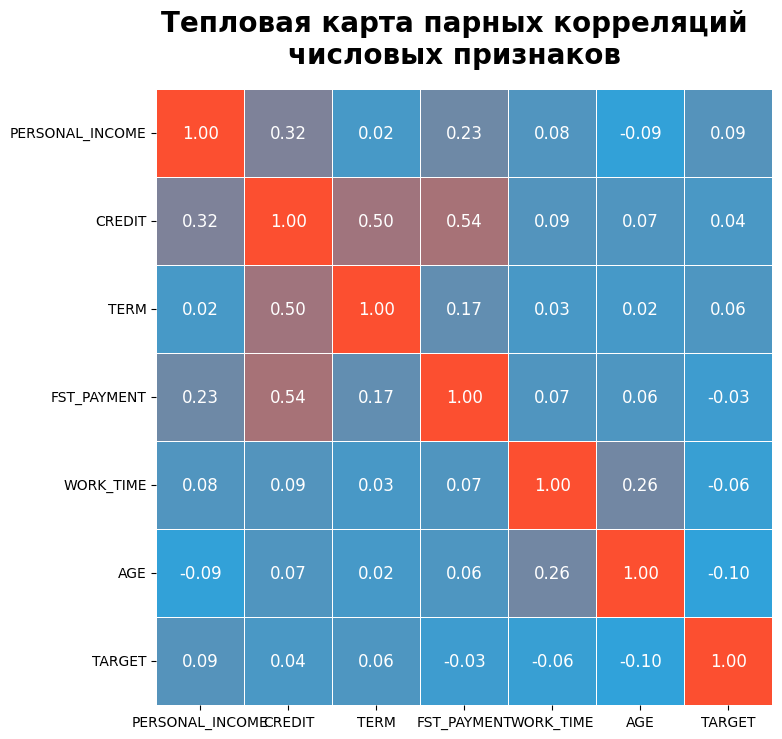

In [ ]:
# Тепловая карта парных корреляций числовых признаков
# ticklabels = [names_cols_dict[col] for col in df_num_plt.columns if col in names_cols_dict]

custom_palette = sns.blend_palette(colors=["#30a2da", "#fc4f30"], as_cmap=True)

fig = plt.figure(figsize=(8, 8))

fig.suptitle(
    "Тепловая карта парных корреляций\nчисловых признаков",
    fontsize=20,
    fontweight="bold",
)

sns.heatmap(
    df_num_plt.corr(),
    cbar=False,
    square=True,
    annot=True,
    annot_kws={"fontsize": 12},
    fmt=".2f",
    cmap=custom_palette,
    linewidth=0.5,
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

- Наименьшая корреляция между `TERM` и `AGE`;
- Сильная положительная корреляция между: </br>
`CREDIT` и `FST_PAYMENT` (0.54) </br>
`CREDIT` и `TERM` (0.50) </br>
`CREDIT` и `PERSONAL_INCOME` (0.32) </br>
- Корреляция между признаками и целевой переменной `TARGET`: </br>
`AGE` > `PERSONAL_INCOME` > `WORK_TIME` > `CREDIT` > `FST_PAYMENT`

__Медианные значения числовых переменных для клиентов с откликом и без__

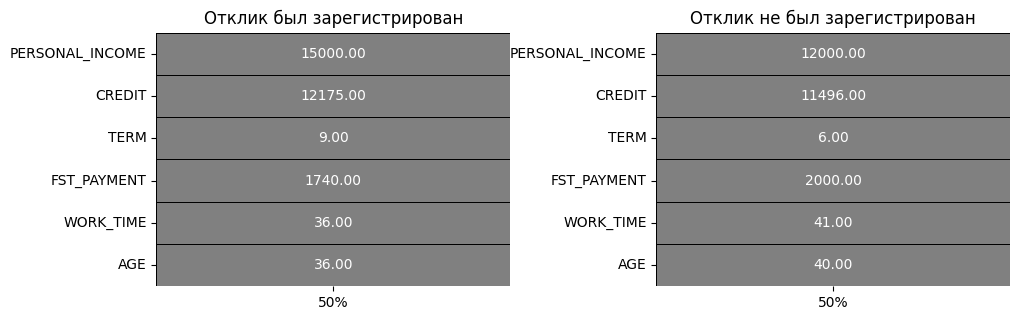

In [ ]:
# Визуализируем распределение медианы по группам клиентов с откликом и без
colors = ["grey", "grey"]

churn = df_full[df_full["TARGET"] == 1].drop("AGREEMENT_RK", axis=1).describe().T
not_churn = df_full[df_full["TARGET"] == 0].drop("AGREEMENT_RK", axis=1).describe().T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.heatmap(
    churn[["50%"]],
    annot=True,
    cmap=colors,
    linewidths=0.4,
    linecolor="black",
    cbar=False,
    fmt=".2f",
)
plt.title("Отклик был зарегистрирован")

plt.subplot(1, 2, 2)
sns.heatmap(
    not_churn[["50%"]],
    annot=True,
    cmap=colors,
    linewidths=0.4,
    linecolor="black",
    cbar=False,
    fmt=".2f",
)
plt.title("Отклик не был зарегистрирован")

fig.tight_layout(pad=0)

Критерии клиента чаще всего откликающегося на предложения банка (числовые переменные):
- Более высокий **персональный доход** 15000 р. против 12000 р.;
- Более высокая **сумма последнего кредита** 12175 р. против 11496 р.;
- Более длительный **срок кредита** 9 мес. против 6 мес.;
- Меньшим **первоначальным взносом** 1740 р. против 2000 р.;
- Меньшим **временем работы** на последнем месте 36 мес. против 41 мес.;
- Меньшим **возрастом** 36 лет против 40.


## 5.2 Визуальный анализ категориальных переменных

__Анализ целевой переменной__

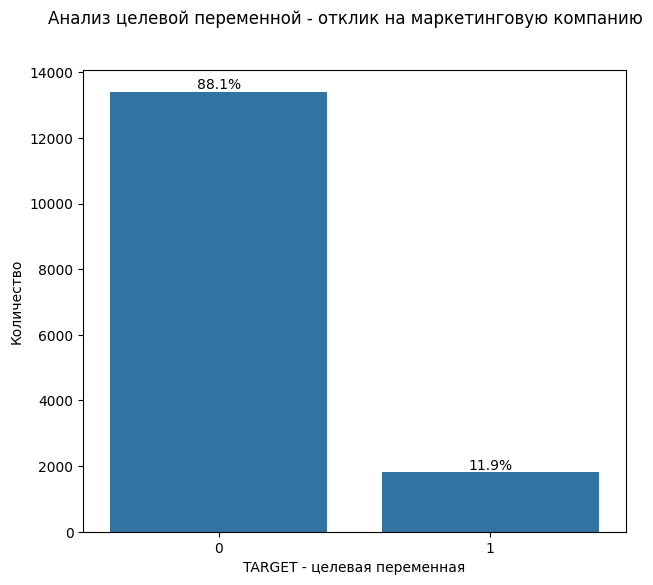

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.countplot(x="TARGET", data=df_full)

ax.set_ylabel("Количество")
ax.set_xlabel("TARGET - целевая переменная")

total = df_full["TARGET"].count()
ax.bar_label(ax.containers[0], fmt=lambda x: f"{(x/total)*100:0.1f}%")

plt.suptitle("Анализ целевой переменной - отклик на маркетинговую компанию")
plt.show()

- Данные сильно несбалансированны. Более 88% данных отностятся к классу 0 (отклика не было) и менее 12% данных относятся к классу 1 (отклик был зарегистрирован).
- В следстивии чего последующие прогнозы могут быть смещены в сторону клиентов **без отклика**;
- Далее визуализация должна учесть этот дисбаланс.

__Анализ бинарных признаков__

[kaggle - link](https://www.kaggle.com/code/subinium/categorical-data-eda-visualization)

In [ ]:
# Столбцы с бинарными признаками
binary_cols = [
    "CLOSED_FL",
    "GENDER",
    "SOCSTATUS_WORK_FL",
    "SOCSTATUS_PENS_FL",
    "FL_PRESENCE_FL",
]

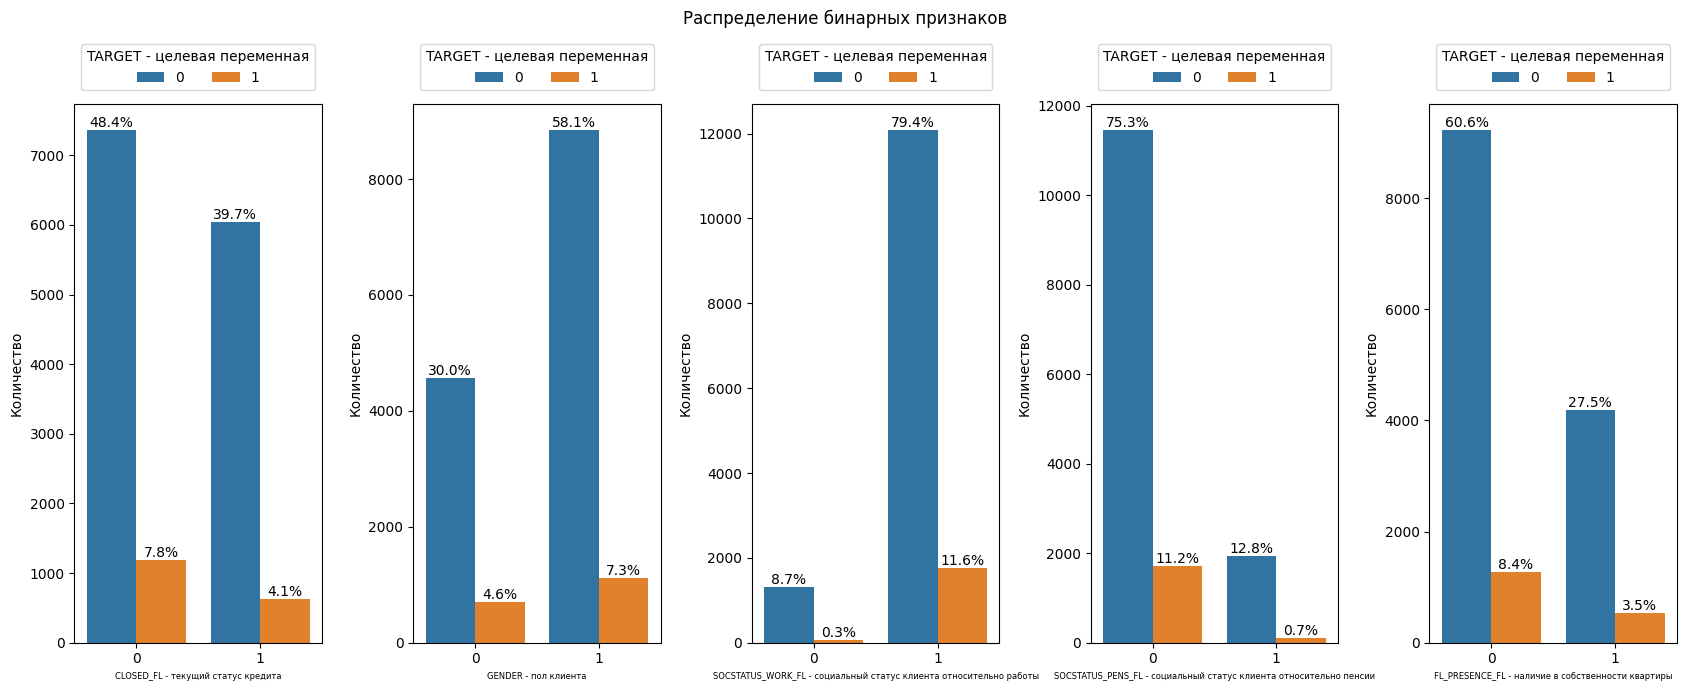

In [ ]:
# Визуализируем распределение столбцов с бинарными признаками
f, axs = plt.subplots(1, len(binary_cols), figsize=(17, 7))
for ax, col in zip(axs, binary_cols):
    sns.countplot(data=df_full[binary_cols], x=col, hue=df_full["TARGET"], ax=ax)

    sns.move_legend(
        ax,
        title=names_cols_dict["TARGET"],
        loc="lower center",
        bbox_to_anchor=(0.5, 1),
        ncol=2,
        borderaxespad=1,
        frameon=True,
    )

    ax.set_ylabel("Количество")
    ax.set_xlabel(names_cols_dict[col], fontsize=6)

    total = df_full[col].count()
    ax.bar_label(ax.containers[0], fmt=lambda x: f"{(x/total)*100:0.1f}%")
    ax.bar_label(ax.containers[1], fmt=lambda x: f"{(x/total)*100:0.1f}%")

    f.suptitle("Распределение бинарных признаков")
f.tight_layout()

In [ ]:
# Оценим долю отклика на предложение банка
# Стоит обратить внимание на количество наблюдений в категориях (репрезентативность)
for col in df_full[binary_cols]:
    data = df_full[[col, "TARGET"]].groupby(col)["TARGET"].value_counts().unstack()
    data["count"] = data[0] + data[1]
    data["rate"] = data[1] / data["count"]
    data.sort_values(by=["count"], ascending=False, inplace=True)

    display(data.style.highlight_max(color="green").highlight_min(color="#cd4f39"))

Критерии клиента чаще всего откликающегося на предложения банка (бинарные переменные):
- Закрытый **статус кредита**;
- Женский **пол**;
- Однозначно **работающе клиенты**;
- Не имеющие собственного **жилья**.


__Анализ мультиноминальных признаков__

In [ ]:
# Столбцы с мультиномиальными признаками
nomial_cols = [
    "FAMILY_INCOME",
    "GEN_INDUSTRY",
    "GEN_TITLE",
    "JOB_DIR",
    "EDUCATION",
    "MARITAL_STATUS",
    "CHILD_TOTAL",
    "DEPENDANTS",
    "POSTAL_ADDRESS_PROVINCE",
    "OWN_AUTO",
]

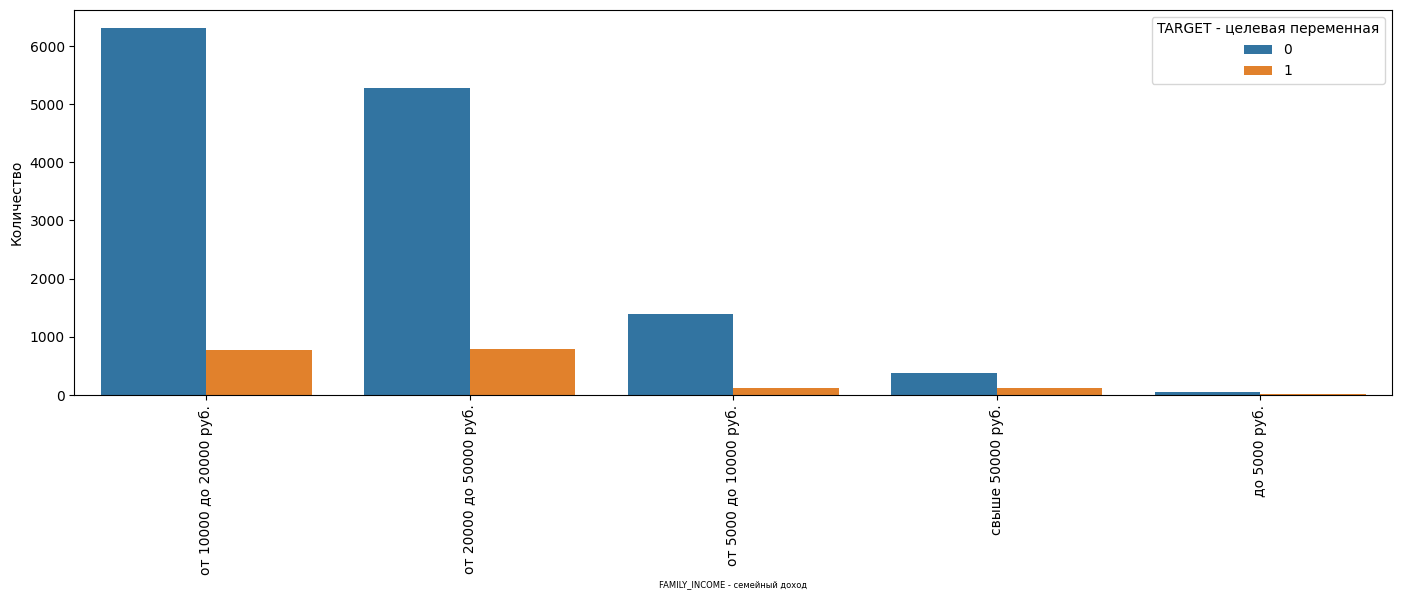

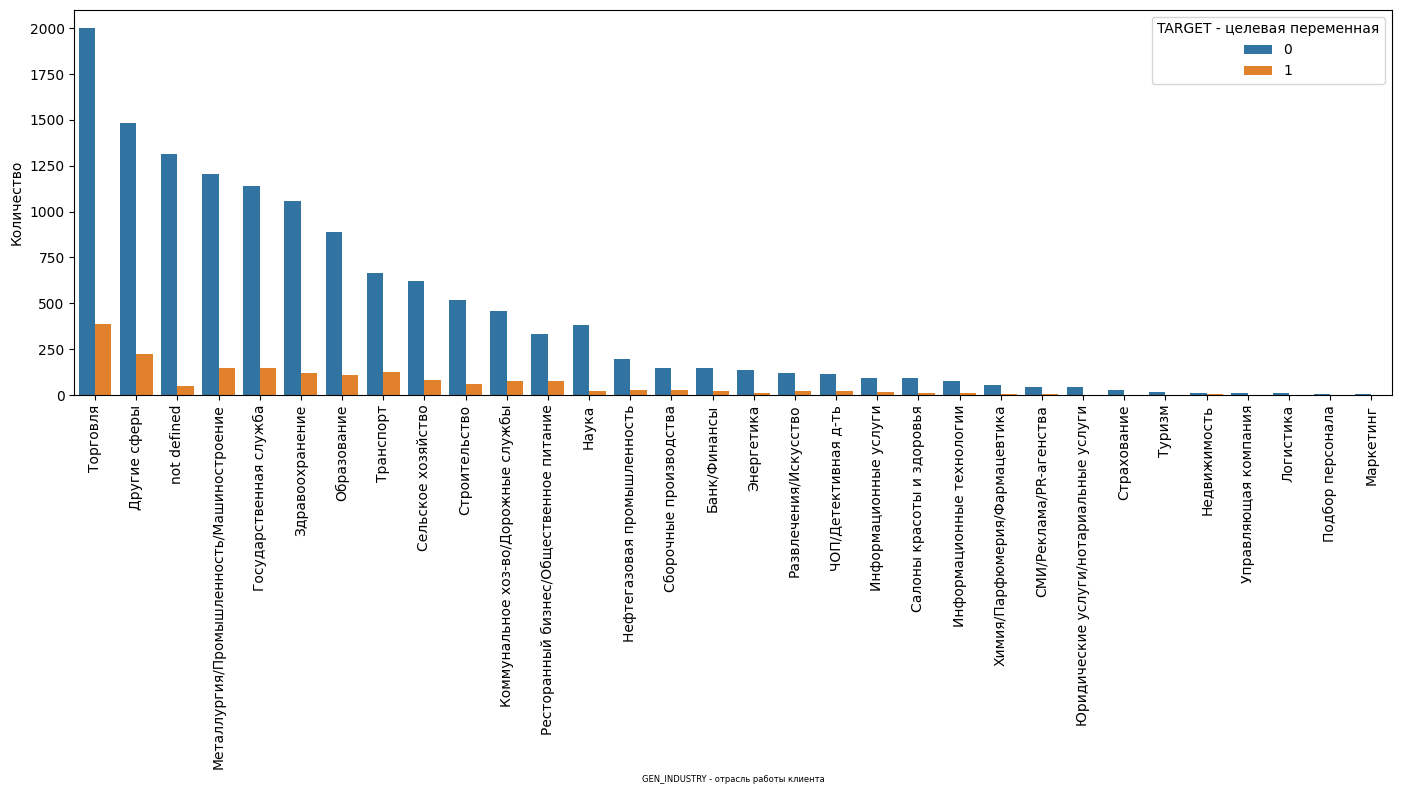

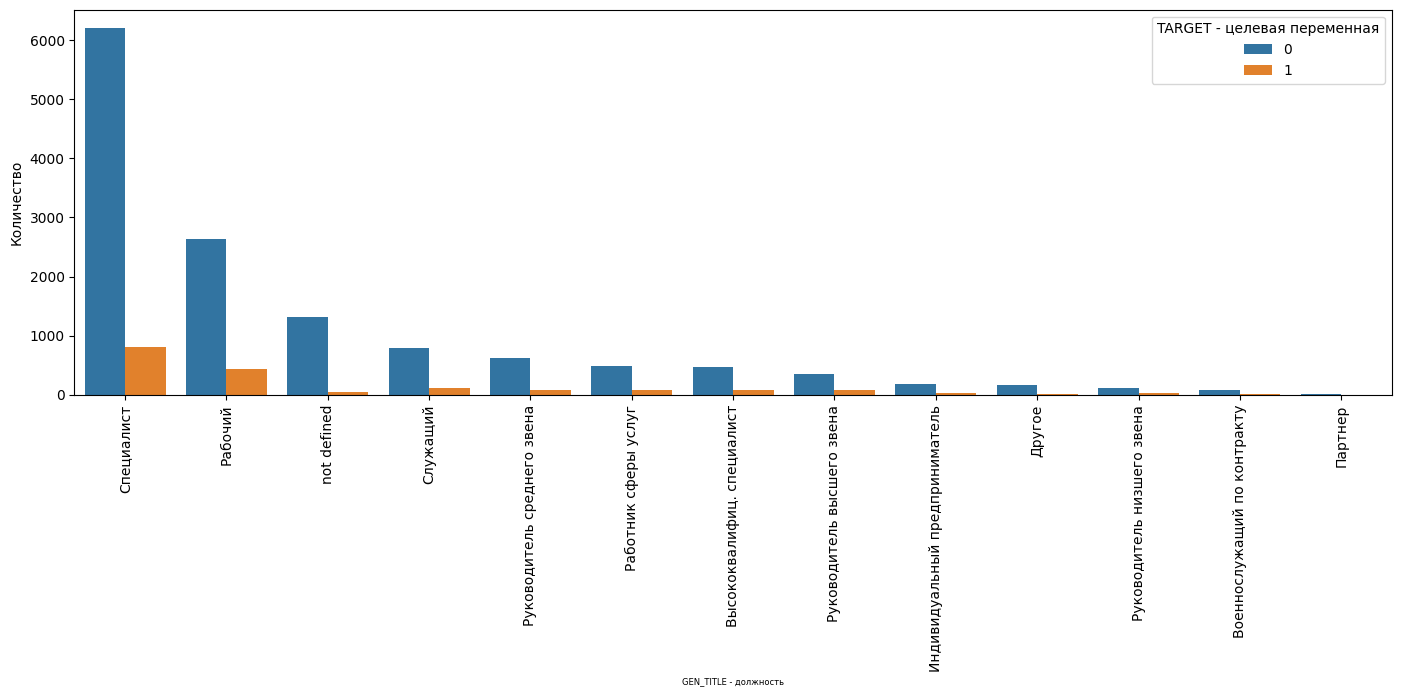

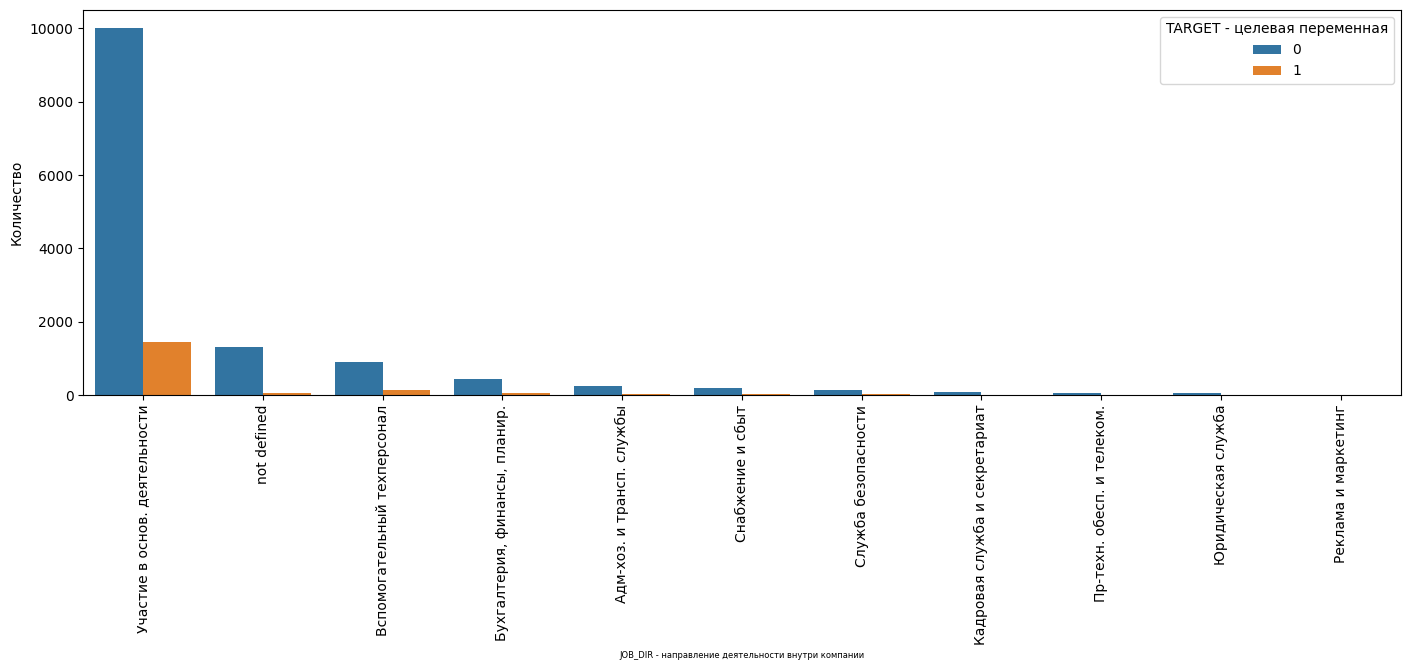

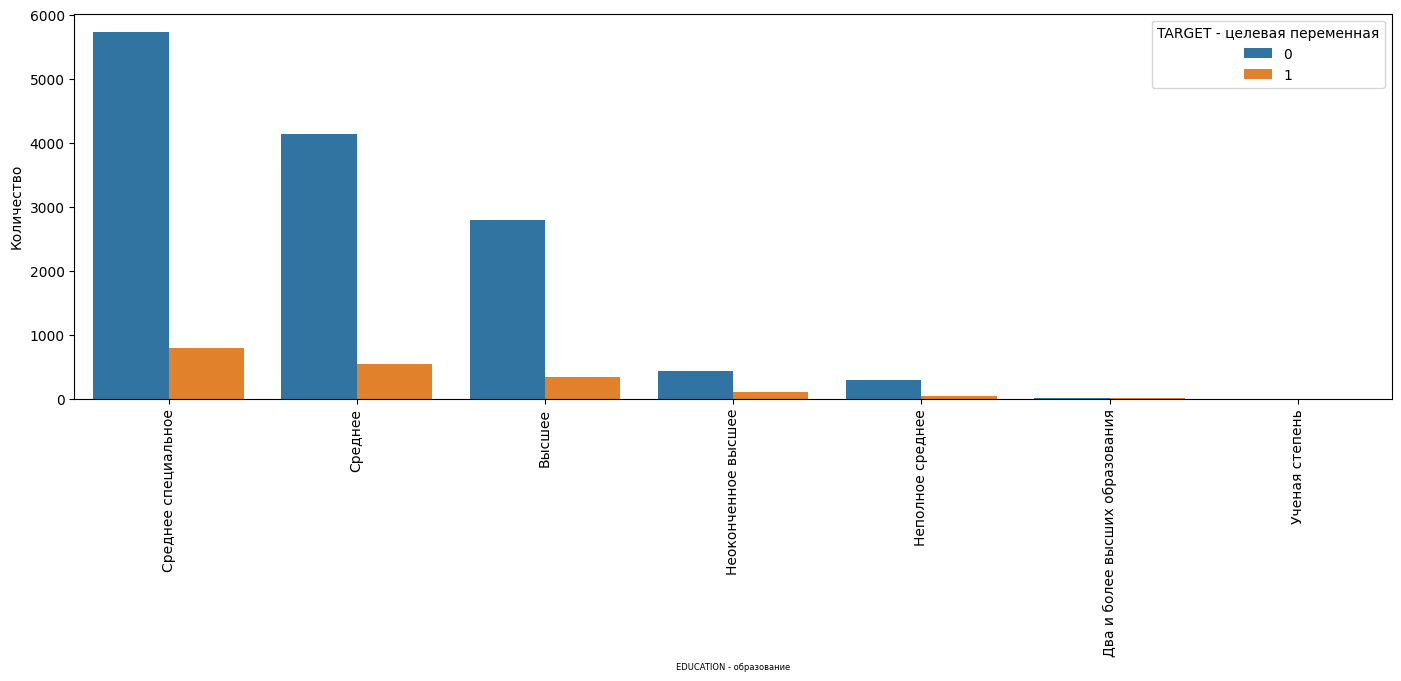

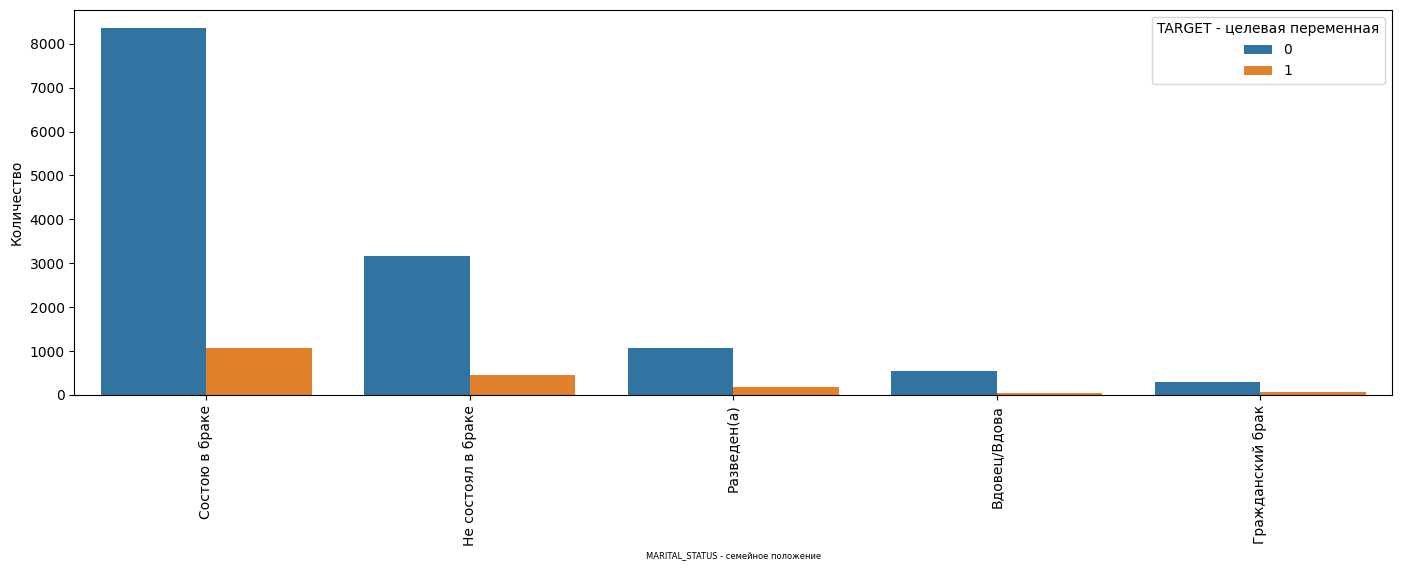

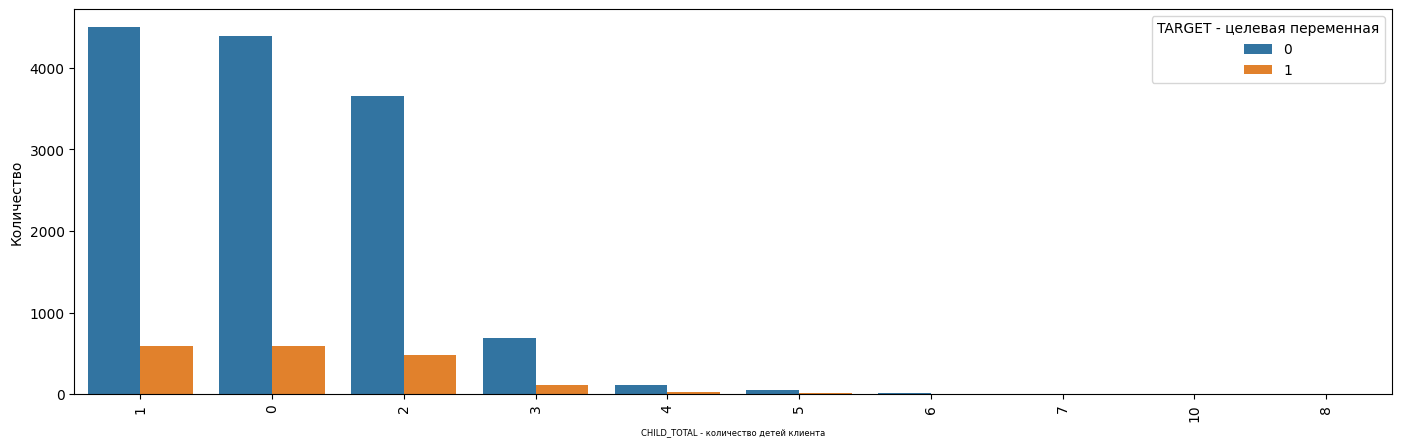

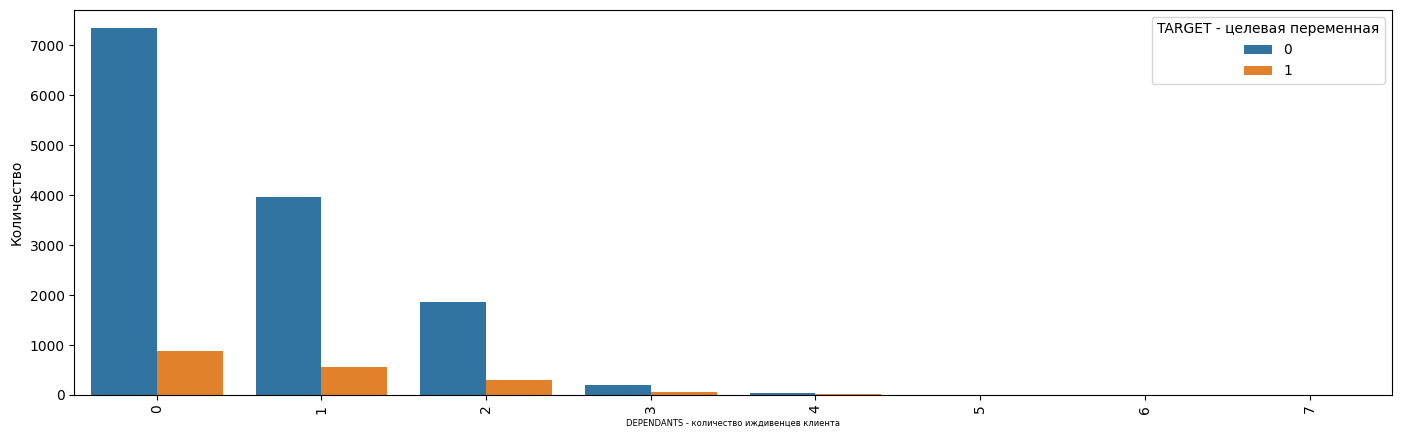

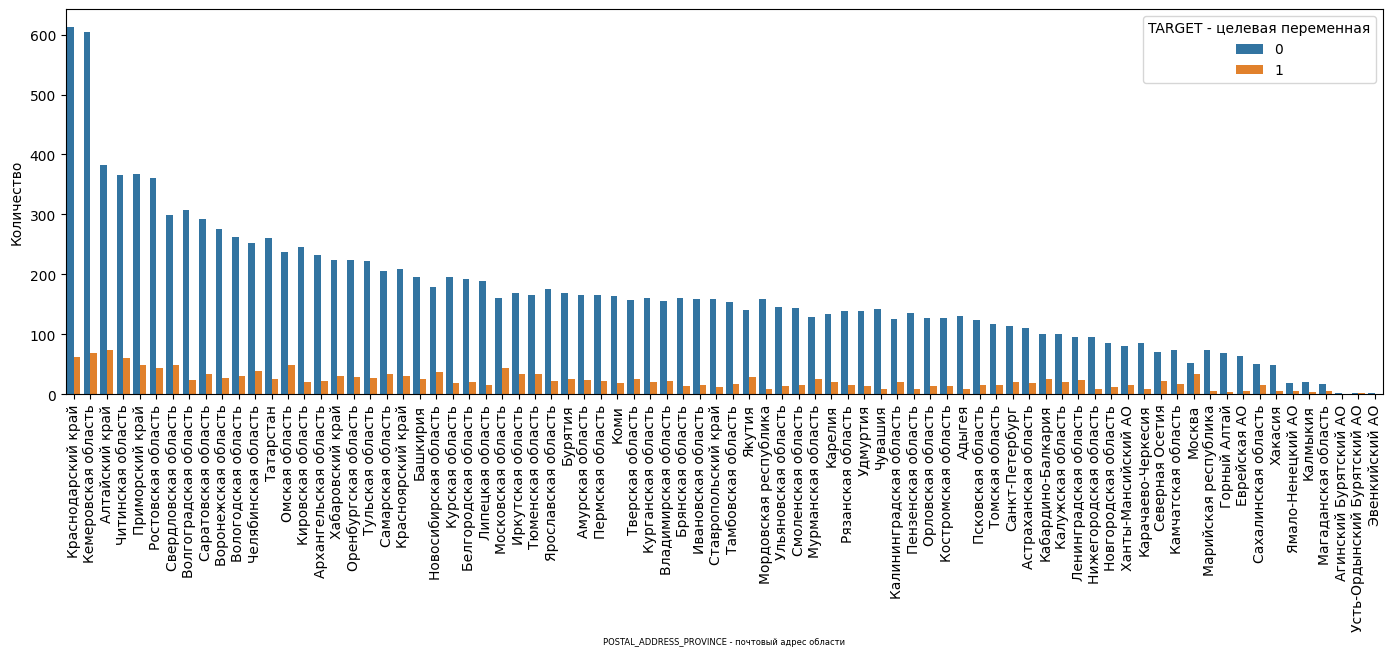

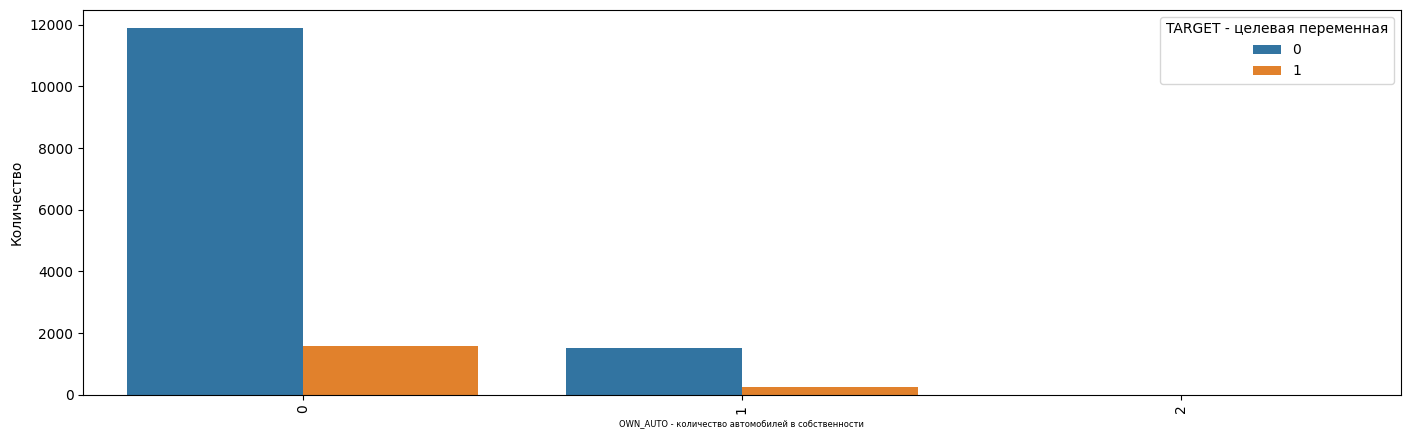

In [ ]:
# Визуализируем распределение столбцов с мультиномиальными признаками
for col in df_full[nomial_cols]:
    fig, ax = plt.subplots(figsize=(17, 5))
    sns.countplot(
        data=df_full[nomial_cols],
        x=col,
        hue=df_full["TARGET"],
        order=df_full[col].value_counts().index,
    )

    sns.move_legend(ax, title=names_cols_dict["TARGET"], loc="best")

    ax.tick_params(axis="x", rotation=90)

    ax.set_ylabel("Количество")
    ax.set_xlabel(names_cols_dict[col], fontsize=6)

    # Отображение процентного соотношения
    # total = df_full[col].count()
    # ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.1f}%', rotation=90)
    # ax.bar_label(ax.containers[1], fmt=lambda x: f'{(x/total)*100:0.1f}%', rotation=90)
    # f.tight_layout()
    plt.show()

In [ ]:
# Оценим долю отклика на маркетинговую кампанию
# Стоит обратить внимание на количество наблюдений в категориях (репрезентативность)
for col in df_full[nomial_cols]:
    data = df_full[[col, "TARGET"]].groupby(col)["TARGET"].value_counts().unstack()
    data["count"] = data[0] + data[1]
    data["rate"] = data[1] / data["count"]
    data.sort_values(by=["count"], ascending=False, inplace=True)

    display(data.style.highlight_max(color="green").highlight_min(color="#cd4f39"))

Критерии клиента чаще всего откликающегося на предложения банка (мультиномиальные переменные):
- **Доход семьи** высокий ~ выше 50000 р.;
- **Отрасли работы** - торговля, транспорт, ресторанный бизнес и недвижимость;
- **Должности** - руководитель высшего и низшего звена, индивидуальный предприниматель и рабочий;
-  **Направление деятельности** - участие в основ. деятельности, снабжение и сбыт и вспомогательный персонал;
- **Образование** - высшее и неоконченное высшее;
- **Семейное положение** - гражданский брак и состоит в браке;
- **Кол-во детей** - 3 и более;
- **Кол-во иждивенцев** - 3 и более;
- **Почтовый адрес** - Алтайский край, Омская, Новосибирская, Тюменская и Ленинградская область;
- **Кол-во авто** - 1.


- [kaggle-EDA-1](https://www.kaggle.com/code/tanmay111999/telco-churn-eda-cv-score-85-f1-score-80)

- [kaggle-EDA-link-2](https://www.kaggle.com/code/tarundirector/binary-classification-bank-churn-eda)

## 5.3 Корреляция всех признаков

__Фик - корреляция__

- [Phik-correlation-kaggle](https://www.kaggle.com/code/doniyordjon/a-short-introduction-to-k)

- [Phik_tutorial_basic](https://colab.research.google.com/github/KaveIO/PhiK/blob/master/phik/notebooks/phik_tutorial_basic.ipynb#scrollTo=5CY50HdfksuR)

- [Phik_tutorial_advanced](https://colab.research.google.com/github/KaveIO/PhiK/blob/master/phik/notebooks/phik_tutorial_advanced.ipynb#scrollTo=8njjgYEBKtt8)


In [ ]:
# Обозначим типы данных
data_types = {
    "TARGET": "categorical",
    "CLOSED_FL": "categorical",
    "FAMILY_INCOME": "ordinal",
    "PERSONAL_INCOME": "interval",
    "CREDIT": "interval",
    "TERM": "interval",
    "FST_PAYMENT": "interval",
    "GEN_INDUSTRY": "categorical",
    "GEN_TITLE": "categorical",
    "JOB_DIR": "categorical",
    "WORK_TIME": "interval",
    "AGE": "interval",
    "GENDER": "categorical",
    "EDUCATION": "categorical",
    "MARITAL_STATUS": "categorical",
    "CHILD_TOTAL": "ordinal",
    "DEPENDANTS": "ordinal",
    "SOCSTATUS_WORK_FL": "categorical",
    "SOCSTATUS_PENS_FL": "categorical",
    "REG_ADDRESS_PROVINCE": "categorical",
    "FACT_ADDRESS_PROVINCE": "categorical",
    "POSTAL_ADDRESS_PROVINCE": "categorical",
    "FL_PRESENCE_FL": "categorical",
    "OWN_AUTO": "ordinal",
}

In [ ]:
# Колонки с интервальными данными
interval_cols = [col for col, v in data_types.items() if v == "interval"]

In [ ]:
def get_corr_matrix(df, types, cols):
    # Корреляционная матрица
    corr_matrix = df[list(types.keys())].phik_matrix(interval_cols=cols, bins=20)
    return corr_matrix

In [ ]:
def get_significance_matrix(df, types, cols):
    # Матрица значимостей корреляции
    significance_matrix = df[list(types.keys())].significance_matrix(
        interval_cols=cols, bins=20
    )
    return significance_matrix

In [ ]:
def get_global_matrix(df, types, cols):
    # Матрица глобальной корреляции
    global_correlation, global_labels = df[list(types.keys())].global_phik(
        interval_cols=cols
    )

    # Переименуем признаки
    new_labels = []

    for val in global_labels:
        if val in names_cols_dict:
            new_labels.append(names_cols_dict[val])
        else:
            new_labels.append(val)

    global_labels = new_labels

    return global_correlation, global_labels

In [ ]:
def outlier_significance_matrix(df, var_1, var_2, cols=None, figsize=(10, 10)):
    # Визуализация значимостей корреляции между двумя признаками
    tmp_interval_cols = [cols]

    outlier_signifs, binning_dict = df_full[[var_1, var_2]].outlier_significance_matrix(
        interval_cols=tmp_interval_cols, retbins=True
    )
    zvalues = outlier_signifs.values
    xlabels = outlier_signifs.columns
    ylabels = outlier_signifs.index

    plot_correlation_matrix(
        zvalues,
        x_labels=xlabels,
        y_labels=ylabels,
        x_label=names_cols_dict[var_2],
        y_label=names_cols_dict[var_1],
        vmin=-5,
        vmax=5,
        title="Таблица значимости корреляции",
        identity_layout=False,
        fontsize_factor=1.2,
        figsize=figsize,
    )

In [ ]:
def get_corr_matrix_table(corr_matrix):

    # Преобрауем в табличный вид корреляционную матрицу
    corr_matrix_table = (
        corr_matrix.stack()
        .reset_index()
        .rename(
            columns={0: "correlation", "level_0": "variable", "level_1": "variable2"}
        )
    )

    # Округлим в столбец correlation_label значения до 1 знака после запятой
    corr_matrix_table["correlation_label"] = corr_matrix_table["correlation"].map(
        "{:.1f}".format
    )

    # Опционально
    # Cменим названия признаков на читаемые
    for col in corr_matrix_table[["variable", "variable2"]]:
        corr_matrix_table[col] = corr_matrix_table[col].map(names_cols_dict)

    return corr_matrix_table

In [ ]:
def get_corr_matrix_top_list(corr_matrix):
    # Преобразуев в треугольную матрицу
    corr_matrix_top_list = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Конвертируем в 1-D список, удалим пропуски
    corr_matrix_top_list = corr_matrix_top_list.unstack().dropna()

    # Отсортируем пары корреляций
    corr_matrix_top_list = corr_matrix_top_list.sort_values(ascending=False)

    # Переименуем столбцы
    corr_matrix_top_list = corr_matrix_top_list.reset_index().rename(
        columns={0: "correlation", "level_0": "variable", "level_1": "variable2"}
    )

    return corr_matrix_top_list

In [ ]:
def get_heatmap(corr_matrix_table):
    # Корреляционная тепловая карта
    plot = (
        alt.Chart(corr_matrix_table)
        .mark_rect(strokeOpacity=0)
        .encode(
            x=alt.X(
                "variable:O", axis=alt.Axis(grid=False, title=None, labelLimit=360)
            ),
            y=alt.Y(
                "variable2:O", axis=alt.Axis(grid=False, title=None, labelLimit=360)
            ),
            color=alt.Color("correlation:Q", scale=alt.Scale(scheme="brownbluegreen")),
        )
        .properties(width=930, height=930)
    )

    text = plot.mark_text(fontSize=15).encode(
        text="correlation_label",
        color=alt.condition(
            ((alt.datum.correlation > 0.75) | (alt.datum.correlation < 0.25)),
            alt.value("white"),
            alt.value("black"),
        ),
    )

    # Отобразим тепловую карту
    return plot + text

__Глобальная корреляция__

Коэффициент глобальной корреляции — это полезная мера, выражающая общую корреляцию одной переменной со всеми другими переменными в наборе данных. Это дает нам представление о том, насколько хорошо одну переменную можно смоделировать с использованием других переменных.

In [ ]:
# Получим данные матрицы глобальной корреляции
global_correlation, global_labels = get_global_matrix(
    df_full, data_types, interval_cols
)

/usr/local/lib/python3.10/dist-packages/phik/phik.py:319: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.sqrt(


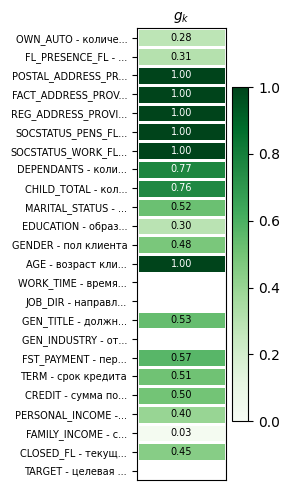

In [ ]:
# Оценим матрицу глобальной корреляции
plot_correlation_matrix(
    global_correlation,
    x_labels=[""],
    y_labels=global_labels,
    vmin=0,
    vmax=1,
    figsize=(3, 5),
    color_map="Greens",
    title=r"$g_k$",
    fontsize_factor=0.7,
)
plt.tight_layout()

Наибольшую корреляцию имеет:
- `почтовый адрес`, `фактический адрес`, `регистрационный адрес`;
- `социальный статус рабочего`, `социальный статус пенсионера` и `возраст`;
- `количество детей`, `количество иждивенцев`;
- все что связанно с `кредитами`.

Перечисленные признаки скорее всего мультиколлинеарны между собой, следовательно стоит произвести их отбор и понять какие стоит исключить. Это необходимо для последующей роботой с предсказательными моделями.

Допустим, что:
- `адреса` попарно коррелируют между собой, так же как и `социальные статусы`, аналогично `количество детей` с `количеством еждивенцев` и информация о `кредитах` попарно коррелирует между собой. Отдельно возраст коррелирует с выше перечисленными признаками кроме `адресов`.

Важно заметить, что корреляция признаков с целевой переменной очень низкая, поэтому хороших результатов от линейных моделей ожидать не стоит.

__Попарная корреляция__

In [ ]:
# Получим корреляционную матрицу
corr_matrix = get_corr_matrix(df_full, data_types, interval_cols)

In [ ]:
# Получим корреляционную таблицу
corr_matrix_table = get_corr_matrix_table(corr_matrix)

In [ ]:
# Визуализируем тепловую карту
get_heatmap(corr_matrix_table)

alt.LayerChart(...)

__Оценим значимость корреляций__

При оценке корреляций следует смотреть не только на коэффициенты, но и на их статистическую значимость. Потому как в конечном итоге большая корреляция может оказаться статистически не значимой и на оборот.

In [ ]:
# Получим матрицу значимостей корреляции
significance_matrix = get_significance_matrix(df_full, data_types, interval_cols)

In [ ]:
# Получим корреляционную таблицу
significance_matrix_table = get_corr_matrix_table(significance_matrix)

In [ ]:
# Визуализируем тепловую карту значимостей корреляции
get_heatmap(significance_matrix_table)

alt.LayerChart(...)

In [ ]:
# Получим список корреляций
corr_matrix_top_list = get_corr_matrix_top_list(corr_matrix)

In [ ]:
# Получим список значимостей корреляций
significance_matrix_top_list = get_corr_matrix_top_list(significance_matrix)

In [ ]:
# Объединим таблицу корреляций и таблицу их значимостей
full_matrix_top_list = corr_matrix_top_list.merge(
    significance_matrix_top_list, on=["variable", "variable2"]
).rename(columns={"correlation_x": "correlation", "correlation_y": "significance"})

In [ ]:
def get_corr_ids(df, cond=0):
    # Признаки, в наибольшей степени коррелирующие между собой - граничное условие - значение > condition
    # Индексы для корреляции
    top_corr_inds = set(df[df["correlation"] > cond].index)

    # Индексы - топ значимостей = кол-ву значимых признаков по условию
    top_sign_inds = set(
        df.sort_values(by="significance", ascending=False)
        .head(len(top_corr_inds))
        .index
    )
    return top_corr_inds, top_sign_inds

In [ ]:
# Получим индексы для всех признаков
top_corr_inds, top_sign_inds = get_corr_ids(full_matrix_top_list, 0.5)

In [ ]:
# Посмотрим на несовпадения двух таблиц
full_matrix_top_list.loc[list(top_corr_inds ^ top_sign_inds)].sort_values(
    by="significance", ascending=False
)

variable      variable2  correlation  significance
25               DEPENDANTS            AGE     0.484015     70.569993
29                      AGE      GEN_TITLE     0.463527     58.116364
28                      AGE        JOB_DIR     0.465802     57.074698
27                      AGE   GEN_INDUSTRY     0.477979     55.085270
22                   GENDER   GEN_INDUSTRY     0.505876     49.540033
23    FACT_ADDRESS_PROVINCE  FAMILY_INCOME     0.500657     47.106634
21  POSTAL_ADDRESS_PROVINCE  FAMILY_INCOME     0.508978     46.697796
15              FST_PAYMENT         CREDIT     0.670575     40.087767

- Отметим что корреляция между `возрастом` и `кол-во иждивенцев` ниже критического значения 0.5, однако имеет самую высокую оценку значимости корреляции из таблицы несовпадения.
- `Величина первого платежа` и `сумма кредита` имеет высокое значение корреляции > 0.5, однако имеет самую низкую оценку значимости корреляции из таблицы несовпадения.

In [ ]:
# Признаки (зеленым), в наибольшей степени коррелирующие между собой и имеющие высокую степень значимости корреляции
display(
    full_matrix_top_list[full_matrix_top_list["correlation"] > 0.5].style.apply(
        lambda x: [
            "background: green" if x.name in list(top_corr_inds & top_sign_inds) else ""
            for i in x
        ],
        axis=1,
    )
)

- Определим интересующие для нас сильные корреляция между: </br>
`возрастом` и `соц. статусом относительно работы` (0.86); </br>
`возрастом` и `количеством детей` и `иждевенцев` (0.75); </br>
`параметрами кредита` (0.67); </br>
`персональным` и `семейным доходом ` (0.61); </br>
`почтовым адресом` и `персональным доходом` (0.50); </br>
`полом` и `отраслью работы` (0.50). </br>

- Высокие "аномальные" корреляции - следствие мультиколлинеарности признаков.

Аналогично посмотрим на корреляцию признаков с целевой переменной

In [ ]:
# Отберем только целевую переменную в строках и признаки с ней коррелирующие
features_with_target_df = full_matrix_top_list[
    (corr_matrix_top_list["variable"] == "TARGET")
    | (full_matrix_top_list["variable2"] == "TARGET")
]

In [ ]:
# Получим индексы для признаков и целевой переменной
top_corr_inds, top_sign_inds = get_corr_ids(features_with_target_df)

In [ ]:
# Признаки, коррелирующие с целевой переменной
display(features_with_target_df.head(10))

variable variable2  correlation  significance
139             GEN_INDUSTRY    TARGET     0.138415     12.097537
140  POSTAL_ADDRESS_PROVINCE    TARGET     0.135638      8.249517
141                      AGE    TARGET     0.132167     12.328038
142        SOCSTATUS_PENS_FL    TARGET     0.131787     11.438955
144    FACT_ADDRESS_PROVINCE    TARGET     0.130662      8.173537
147          PERSONAL_INCOME    TARGET     0.128449     10.572874
155        SOCSTATUS_WORK_FL    TARGET     0.121601     10.861682
156     REG_ADDRESS_PROVINCE    TARGET     0.120996      7.391774
171                CLOSED_FL    TARGET     0.103882      8.246458
177                GEN_TITLE    TARGET     0.097046     10.941619

- Корреляция между основными признаками и целевой переменной `TARGET`: </br>
`отрасль работы` > `возраст` > `почтовый адрес` > `социальный статус` > `персональный доход`

__Выбросы значимости__

Фик-корреляцию между двумя переменными смешанного типа не всегда легко интерпретировать, особенно когда речь идет о категориальных переменных. Воспользуемся функциональностью для обнаружения «выбросов»: забросов и спадов ожидаемых частот в таблице сопряженности двух переменных.

Отдельно посмотрим на признаки с наибольшей корреляцией.

__Возраст и соц. статус относительно работы__

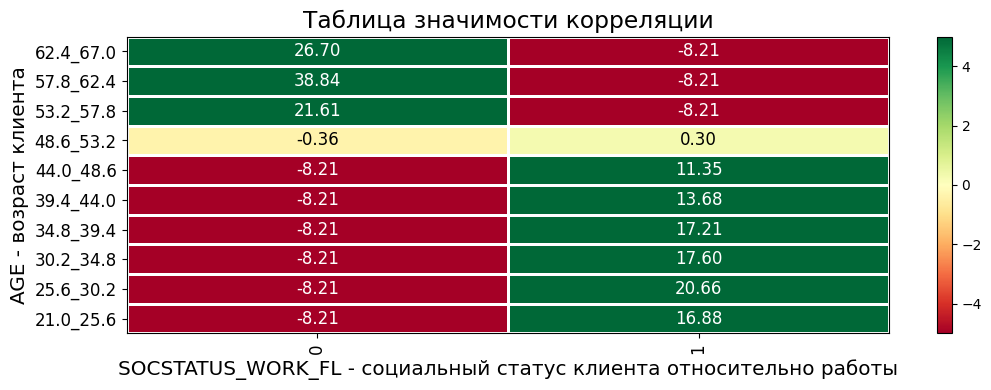

In [ ]:
# Выведем возраст и соц. статус относительно работы
outlier_significance_matrix(df_full, "AGE", "SOCSTATUS_WORK_FL", "AGE", (11, 4))

- Клиент выходит на пенсию после ~ 50 лет.

__Возраст и количеством иждевенцев__

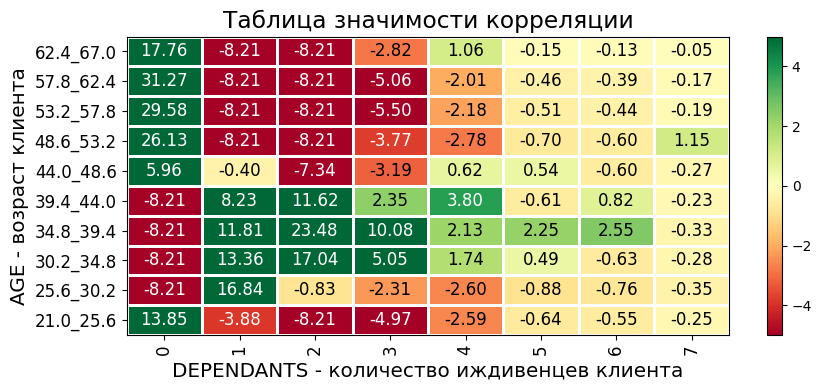

In [ ]:
# Выведем возраст и количество иждевенцев
outlier_significance_matrix(df_full, "AGE", "DEPENDANTS", "AGE", (9, 4))

- Хорошо прослеживается зависимость между возрастом и количеством иждевенцев (по факту - детей, т.к между `DEPENDANTS` и `CHILD_TOTAL` аномально высокая корреляция).

__Срок и сумма последнего кредита__

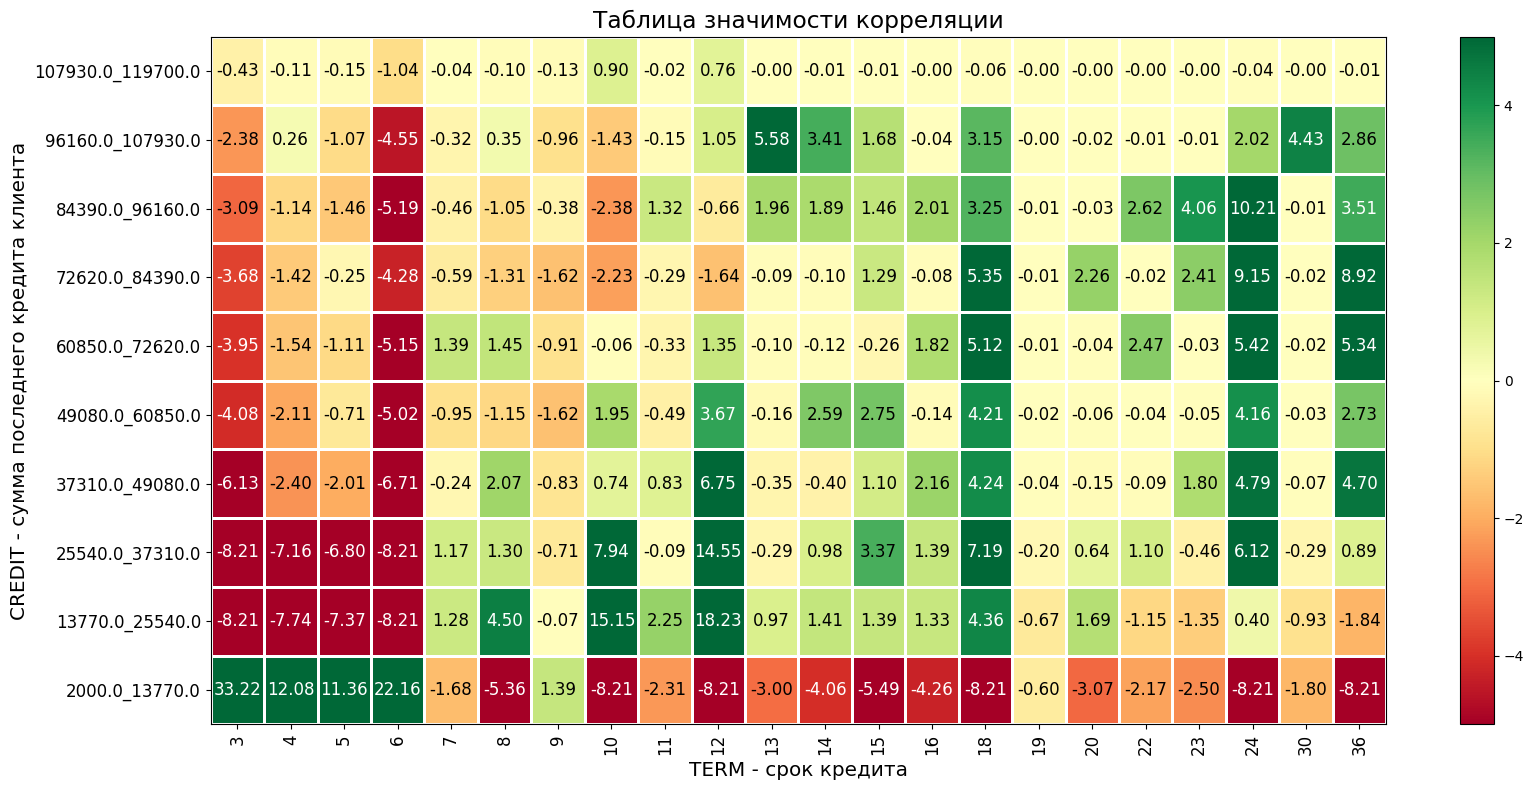

In [ ]:
# Выведем срок и сумму последнего кредита
outlier_significance_matrix(df_full, "CREDIT", "TERM", "CREDIT", (17, 8))

- Чем выше стоимость кредита, тем выше срок на который его берут.

__Почтовый адрес и семейный доход__

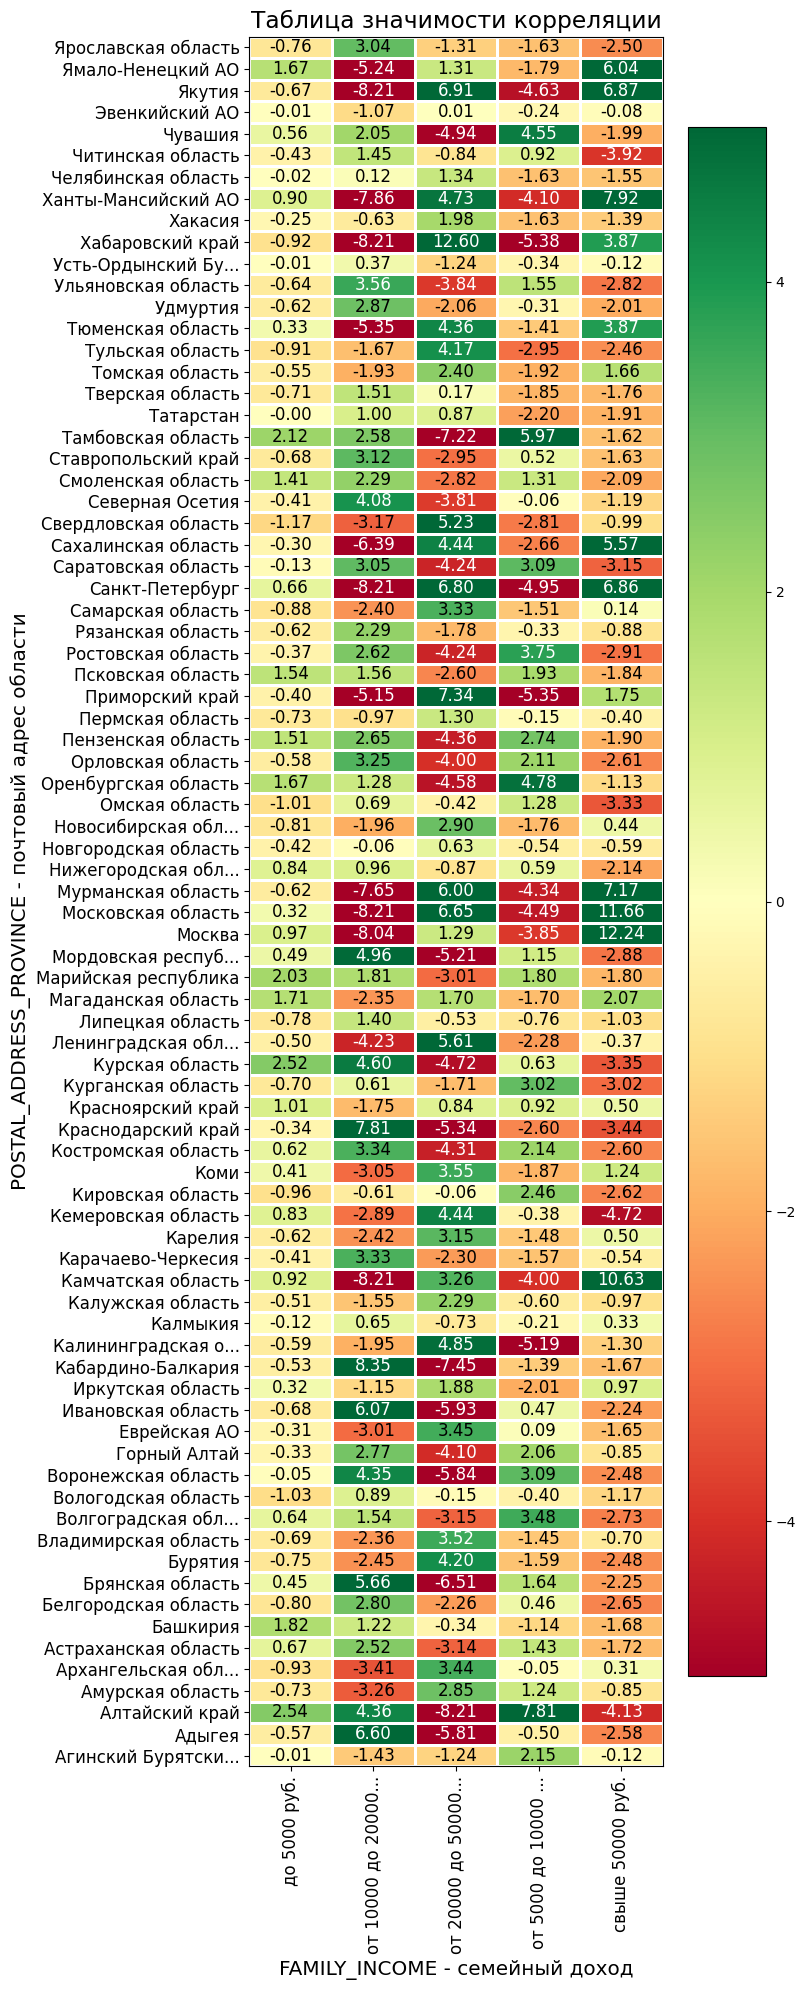

In [ ]:
# Выведем почтовый адрес и семейный доход
outlier_significance_matrix(
    df_full, "POSTAL_ADDRESS_PROVINCE", "FAMILY_INCOME", None, (8, 20)
)

- Самый высокий доход преобладает в Москве, Московкой области, Мурманской области, Санкт-Петербурге, и регионах в который преобладает работа вахтовыми методами - Камчатская область, Сахалинская область, Ханты-Мансийский АО.
- Низкий доход - Алтайский край, Адыгея, Воронежская область, Мордовская республика, Брянская область.

__Пол и отрасль работы (0 - мужской пол, 1 - женский)__

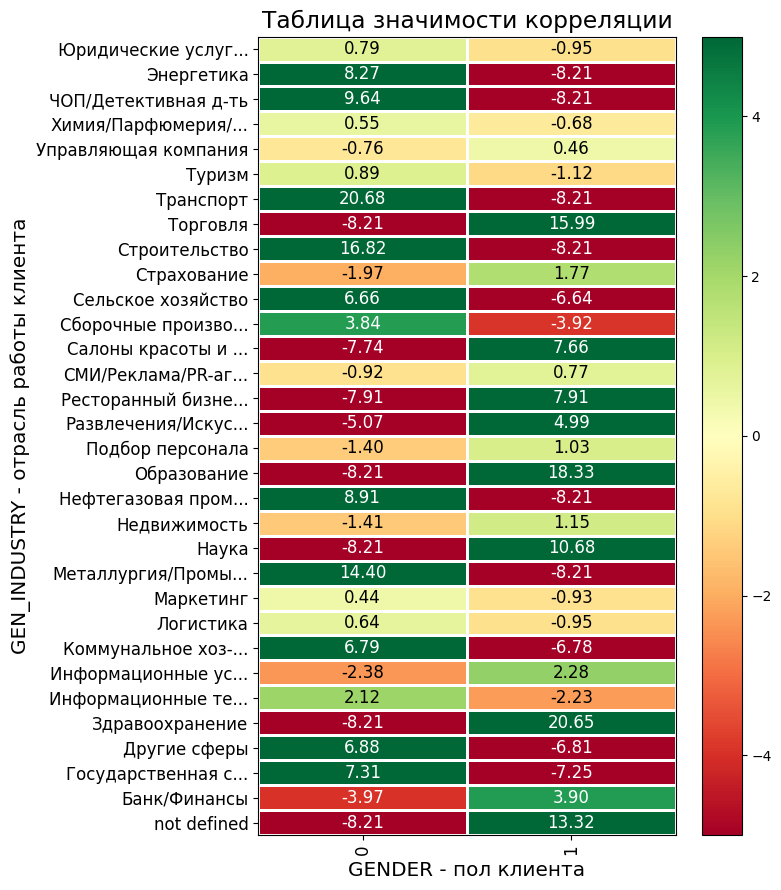

In [ ]:
# Выведем пол и отрасль работы
outlier_significance_matrix(df_full, "GEN_INDUSTRY", "GENDER", None, (8, 9))

- Мужчины преобладают в государственных структурах, промышленности, транспорте, энергетике.
- Женщины в науке, здравохранении, торговле, салонах красоты.

In [ ]:
# Вывод всех попарных зависимостей признаков
# rep = report.correlation_report(df_full[list(data_types.keys())],
#                                 interval_cols = interval_cols,
#                                 significance_threshold=3,
#                                 correlation_threshold=0.5)

__Сохраним очищенные и проанализированные данные__

In [ ]:
# Сохраним единую таблицу
df_full.to_csv(DATA_PATH + "df_full.csv", index=False)

In [ ]:
# Прверим что файл открывается
# df_full = pd.read_csv(DATA_PATH + 'df_full.csv')

# 6 Деление на тренировочную и тестовую выборку

Как было обозначено ранее, данные сильно несбалансированны. Используем стратификацию при разбиении данных.

In [ ]:
# Еще раз проанализируем дисбаланс классов
prop_df_full = sum(df_full["TARGET"]) / len(df_full["TARGET"])
print(f"Доля положительного значения целевой переменной в df_full: {prop_df_full:.5f}")

Доля положительного значения целевой переменной в df_full: 0.11903


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df_full.drop(["TARGET", "AGREEMENT_RK"], axis=1),
    df_full["TARGET"],
    test_size=0.3,
    random_state=42,
    stratify=df_full["TARGET"],
)

In [ ]:
# Оценим пропорции для y_train и y_val
prop_train = sum(y_train) / len(y_train)
prop_val = sum(y_val) / len(y_val)
print(f"Доля положительного значения целевой переменной в y_train: {prop_train:.5f}")
print(f"Доля положительного значения целевой переменной в y_val: {prop_val:.5f}")

Доля положительного значения целевой переменной в y_train: 0.11899
Доля положительного значения целевой переменной в y_val: 0.11912


In [ ]:
# Размерности
df_full.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape

((15223, 25), (10656, 23), (4567, 23), (10656,), (4567,))

In [ ]:
# df_full(15_223, 25) -> X_train(10_656, 24) + y_train(10_656,)
#                     -> X_val(4_567, 24) +    y_val(4_567,)

# 7 Подготовка данных

## 7.1 Подготовка числовых переменных

__Замена пропущенных значений__

Замену пропусков мы произвели ранее на всех данных. Следовательно на этом этапе этот пункт пропустим. Однако, в случае замены пропусков медианными или наиболее частыми значениями, после разбиения на тренировочную и тестовую выборку всегда нужно ориентироваться на данные в тренировочной выборке и произовдить замену в тестовой выборке с её учетом.

In [ ]:
# Замена пропущенных значений в X_train and X_val с учетом медианы столбцов X_train
# for df1 in [X_train, X_val]:
#   for col in numerical:
#     col_median = X_train[col].median()
#     df1[col].fillna(col_median, inplace=True)

In [ ]:
# Проверим наличие пропусков в X_train и X_val
print(
    f"Missing values in X_train = {X_train.isnull().sum().sum()} and Missing values in X_train = {X_val.isnull().sum().sum()}"
)

Missing values in X_train = 0 and Missing values in X_train = 0


__Ограничим максимальные значения и заменим выбросы значением в соответствии с выбранным квантилем__

Квантиль выбираем с учетом графиков [п.5 Визуальный анализ числовых переменных/Графики распределения числовых переменных](https://colab.research.google.com/drive/1VDJS35-Df7_6ApivwwGTtobnN65_10x3#scrollTo=5ynXizV4PJCq&line=3&uniqifier=1)

In [ ]:
# Удалим AGREEMENT_RK из перменной с числовыми признаками
numerical.remove("AGREEMENT_RK")

In [ ]:
# Найдем выбросы свыше 0.996 квантиля по X_train
dict_upperbound_num = {}

for col in numerical:
    upper_fence = X_train[col].quantile(0.996)
    dict_upperbound_num[col] = upper_fence

In [ ]:
# Функция замены выбросов значением соответствующем квантилю
def max_value(df2, col, top):
    return np.where(df2[col] > top, top, df2[col])

In [ ]:
# Произведем замену в X_train и X_val аномальных значений
for df2 in [X_train, X_val]:
    for col in dict_upperbound_num:
        df2[col] = max_value(df2, col, dict_upperbound_num[col])

In [ ]:
# Оценим числовые переменные
X_train[numerical].agg(["mean", "median", "min", "max"])

PERSONAL_INCOME        CREDIT       TERM   FST_PAYMENT   WORK_TIME  \
mean       13779.488848  14600.213168   8.058371   3351.550134   75.641892   
median     12000.000000  11598.000000   6.000000   2000.000000   40.000000   
min         1950.000000   2000.000000   3.000000      0.000000   -1.000000   
max        50000.000000  85457.580000  24.000000  40314.320000  444.000000   

              AGE  
mean    40.453453  
median  39.000000  
min     21.000000  
max     64.000000

Значения выбросов столбцов ограничены.

__Логарифмируем ассиметричные распределения__

In [ ]:
# Функция для замены нулевых значений в столбцах значением 1.0e-10
def zero_change(data, variable):
    for col in variable:
        data[col] = np.where(data[col] > 1.0e-10, data[col], 1.0e-10)

In [ ]:
# Функция для определения косинесс для каждого столбца при помощи skew()
def log1p_cols(data, variable):
    # Получим столбцы с косинесс значением выше 0.75
    skewed_features = data[variable].skew()[data[variable].skew() > 0.75].index.values

    # Перечислим столбцы из условия для логарифмирования
    print("Признаки для логарифмирования (косинесс > 0.75):")
    display(skewed_features)

    # Заменим нулевые значения в столбцах значением 1.0e-10
    zero_change(data, variable)

    # Применим log1p преобразование
    data[skewed_features] = np.log1p(data[skewed_features])

In [ ]:
# Логарифмируем столбцы для Train
log1p_cols(X_train, numerical)

Признаки для логарифмирования (косинесс > 0.75):


array(['PERSONAL_INCOME', 'CREDIT', 'TERM', 'FST_PAYMENT', 'WORK_TIME'],
      dtype=object)

In [ ]:
# Логарифмируем столбцы для Val
log1p_cols(X_val, numerical)

Признаки для логарифмирования (косинесс > 0.75):


array(['PERSONAL_INCOME', 'CREDIT', 'TERM', 'FST_PAYMENT', 'WORK_TIME'],
      dtype=object)

## 7.2 Подготовка категориальных переменных

__Кодирование категориальных переменных__

Используем **OneHotEncoder** для кодирования бинарных признаков

In [ ]:
# # Создадим копию X_train/val_encode
# X_train_encode = X_train.copy()
# X_val_encode = X_val.copy()

In [ ]:
# # Создадим трансформер для обработки столбцов
# # Игнорирование категории которой нет в тестовом наборе данных - handle_unknown='ignore' (возвтра вектора с нулями)
# transformer = make_column_transformer(
#     (OneHotEncoder(handle_unknown='ignore'),
#      binary_cols))

In [ ]:
# # Обучаемся на X_train_encode
# transformed = transformer.fit_transform(X_train_encode[binary_cols])

# # Трансформируем
# transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

# # One-hot encoding меняем индекса
# transformed_df.index = X_train_encode.index

# # Собираем таблицы
# X_train_encode = pd.concat([X_train_encode, transformed_df], axis=1)

# # Удаляем старые назмания колонок
# X_train_encode.drop(binary_cols, axis=1, inplace=True)

In [ ]:
# # Трансформируем X_val_encode
# transformed = transformer.transform(X_val_encode[binary_cols])
# transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# transformed_df.index = X_val_encode.index
# X_val_encode = pd.concat([X_val_encode, transformed_df], axis=1)
# X_val_encode.drop(binary_cols, axis=1, inplace=True)

In [ ]:
# X_val_encode.shape, X_train_encode.shape

Используем **Target Encoding - Mean Likelihood Encoding** для кодирования мультиномиальных признаков

- [mean-likelihood-encodings-kaggle](https://www.kaggle.com/code/vprokopev/mean-likelihood-encodings-a-comprehensive-study)

- [kaggle-sample-1](https://www.kaggle.com/code/tanmay111999/telco-churn-eda-cv-score-85-f1-score-80)
- [kaggle-sample-2](https://www.kaggle.com/code/akhiljethwa/playground-s4e1-eda-modeling-xgboost#3.-Modelling-)
- [kaggle-sample-3](https://www.kaggle.com/code/tarundirector/binary-classification-bank-churn-eda)

In [ ]:
# df_full(15_223, 25) -> X_train(10_656, 24) + y_train(10_656,)
#                     -> X_val(4_567, 24) +    y_val(4_567,)

# 8 Предсказание

## 8.0 Utils - некоторые вспомогательные функции

In [ ]:
# Функция для сохранения и открытия модели

# Save folder name
folder = "/content/drive/MyDrive/HSE ML&HLS/ММОВС23/1 - курс/5 - Прикладной Python/1-hw-streamlit/logs"

# Импортирование библиотек, подключение гугл диска
# import _pickle as cPickle
from google.colab import drive

drive.mount("/content/drive")


# Функция для сохранения модели
def save_model(model_save_name, model):
    path = f"{folder}/{model_save_name}"

    with open(path, "wb") as output_file:
        cPickle.dump(model, output_file)


# Функция для чтения модели
def open_model(model_name):
    path = f"{folder}/{model_name}"

    with open(path, "rb") as input_file:
        model = cPickle.load(input_file)

    return model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Функция для создания предсказаний значений классов и их вероятностей


def get_pred_cls_and_probs(model, X_train, X_val):
    # Предсказанные классы
    y_pred_train, y_pred_val = model.predict(X_train), model.predict(X_val)

    # Предсказанные вероятности для класса 1
    y_pred_train_proba, y_pred_val_proba = (
        model.predict_proba(X_train)[:, 1],
        model.predict_proba(X_val)[:, 1],
    )

    return y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba

In [ ]:
# Функция для создания таблицы с помощью которой происходит отслеживание разных моделей

# from datetime import datetime
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import defaultdict

# Словарь для сохранения метрик моделей
results = defaultdict(
    lambda: {
        "date": 0,
        "model_name": 0,
        "model_type": 0,
        "model": 0,
        "scores": [
            {
                "train_scores": {
                    "train_accuracy": 0,
                    "train_precision": 0,
                    "train_recall": 0,
                    "train_f1_score": 0,
                    "train_roc_auc": 0,
                }
            },
            {
                "val_scores": {
                    "val_accuracy": 0,
                    "val_precision": 0,
                    "val_recall": 0,
                    "val_f1_score": 0,
                    "val_roc_auc": 0,
                }
            },
        ],
    }
)


# Функция для подсчета базовых метрик
def get_scores(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    return accuracy, precision, recall, f1, roc_auc


# Функция для добавления в словарь базовых метрик
def get_results_dict(
    id,
    model_save_name,
    classifier,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
):
    date_now = datetime.now().strftime("%Y-%m-%d %H:%M")

    model_name = model_save_name
    model_type = type(classifier).__name__

    train_accuracy, train_precision, train_recall, train_f1_score, train_roc_auc = (
        get_scores(y_train, y_pred_train, y_pred_train_proba)
    )

    val_accuracy, val_precision, val_recall, val_f1_score, val_roc_auc = get_scores(
        y_val, y_pred_val, y_pred_val_proba
    )

    # Задать id эксперимента
    results[id]

    # Задать дату
    results[id]["date"] = date_now

    # Задать имя сохраненной модели
    results[id]["model_name"] = model_name

    # Задать тип модели
    results[id]["model_type"] = model_type

    # Задать модель
    results[id]["model"] = classifier

    # # Задать параметры модели
    # results[id]['params'] = params

    # Задать результаты на train
    results[id]["scores"][0]["train_scores"]["train_accuracy"] = train_accuracy
    results[id]["scores"][0]["train_scores"]["train_precision"] = train_precision
    results[id]["scores"][0]["train_scores"]["train_recall"] = train_recall
    results[id]["scores"][0]["train_scores"]["train_f1_score"] = train_f1_score
    results[id]["scores"][0]["train_scores"]["train_roc_auc"] = train_roc_auc

    # Задать результаты на val
    results[id]["scores"][1]["val_scores"]["val_accuracy"] = val_accuracy
    results[id]["scores"][1]["val_scores"]["val_precision"] = val_precision
    results[id]["scores"][1]["val_scores"]["val_recall"] = val_recall
    results[id]["scores"][1]["val_scores"]["val_f1_score"] = val_f1_score
    results[id]["scores"][1]["val_scores"]["val_roc_auc"] = val_roc_auc

    return results[id]

    # Подготовка словаря для итоговой таблицы


def get_results_df(results):
    flattened_data = []
    for key, value in results.copy().items():
        results_data = {}
        results_data["Date"] = value["date"]
        results_data["Model Name"] = value["model_name"]
        results_data["Model Type"] = value["model_type"]
        results_data["Model"] = value["model"]

        for score in value["scores"]:
            if "train_scores" in score:
                for train_score_key, train_score_value in score["train_scores"].items():
                    results_data[train_score_key] = train_score_value
            elif "val_scores" in score:
                for val_score_key, val_score_value in score["val_scores"].items():
                    results_data[val_score_key] = val_score_value
            else:
                print("Error")

        flattened_data.append(results_data)

    # Итоговая таблица
    results_df = pd.DataFrame(flattened_data)

    # Организация итоговой таблицы
    results_df = results_df[
        [
            "Date",
            "Model Name",
            "Model Type",
            "Model",
            "train_accuracy",
            "val_accuracy",
            "train_precision",
            "val_precision",
            "train_recall",
            "val_recall",
            "train_f1_score",
            "val_f1_score",
            "train_roc_auc",
            "val_roc_auc",
        ]
    ]

    results_df["Date"] = pd.to_datetime(results_df["Date"], format="%Y-%m-%d %H:%M")
    return results_df

In [ ]:
# Функция для отображения метрик
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_auc_score


def evaluate_model_classification(classifier, X_train, y_train, X_val, y_val):
    cm_train = confusion_matrix(y_train, classifier.predict(X_train))
    cm_val = confusion_matrix(y_val, classifier.predict(X_val))

    """            True      False
     Posirtive  [0,0 (TP)  0,1 (FP)]
     Negative   [1,0 (FN)  1,1 (TN)]   """

    TP_train, TP_val = cm_train[0, 0], cm_val[0, 0]
    TN_train, TN_val = cm_train[1, 1], cm_val[1, 1]
    FP_train, FP_val = cm_train[0, 1], cm_val[0, 1]
    FN_train, FN_val = cm_train[1, 0], cm_val[1, 0]

    precision_train, precision_val = TP_train / float(
        TP_train + FP_train
    ), TP_val / float(TP_val + FP_val)

    recall_train, recall_val = TP_train / float(TP_train + FN_train), TP_val / float(
        TP_val + FN_val
    )

    fpr_train, fpr_val = FP_train / float(FP_train + TN_train), FP_val / float(
        FP_val + TN_val
    )

    specificity_train, specificity_val = TN_train / float(
        TN_train + FP_train
    ), TN_val / float(TN_val + FP_val)

    f1_score_train, f1_score_val = 2 * (precision_train * recall_train) / (
        precision_train + recall_train
    ), 2 * (precision_val * recall_val) / (precision_val + recall_val)

    ROC_AUC_train, ROC_AUC_val = roc_auc_score(
        y_train, y_pred_train_proba
    ), roc_auc_score(y_val, y_pred_val_proba)

    print("Train Support : {}".format(dict(y_train.value_counts())))
    print("-" * 50)
    print("Train Confusion Matrix:")
    print(cm_train)
    print("-" * 50)
    print(
        "Train Accuracy : {0:0.4f}".format(
            accuracy_score(y_train, classifier.predict(X_train))
        )
    )
    print("Train Precision : {0:0.4f}".format(precision_train))
    print("Train Recall/Sensitivity/TPR : {0:0.4f}".format(recall_train))
    print("Train FPR (1 - Specificity): {0:0.4f}".format(fpr_train))
    print("Train specificity : {0:0.4f}".format(specificity_train))
    print("Train f1-score : {0:0.4f}".format(f1_score_train))
    print("-" * 50)
    print("Train ROC AUC : {:.4f}".format(ROC_AUC_train))

    print(" " * 50)
    print(" " * 50)

    print("Val Support : {}".format(dict(y_val.value_counts())))
    print("-" * 50)
    print("Val Confusion Matrix:")
    print(cm_val)
    print("-" * 50)
    print(
        "Val Accuracy : {0:0.4f}".format(
            accuracy_score(y_val, classifier.predict(X_val))
        )
    )
    print("Val Precision : {0:0.4f}".format(precision_val))
    print("Val Recall/Sensitivity/TPR : {0:0.4f}".format(recall_val))
    print("Val FPR (1 - Specificity) : {0:0.4f}".format(fpr_val))
    print("Val specificity : {0:0.4f}".format(specificity_val))
    print("Val f1-score : {0:0.4f}".format(f1_score_val))
    print("-" * 50)
    print("Val ROC AUC : {:.4f}".format(ROC_AUC_val))

__Обновим типы признаков__

In [ ]:
# Переопределим числовые переменные X_train
numerical = [var for var in X_train.columns if X_train[var].dtype != "O"]

print("Всего {} категориальных переменных\n".format(len(numerical)))
print("Категориальные переменные:", numerical)

Всего 6 категориальных переменных

Категориальные переменные: ['PERSONAL_INCOME', 'CREDIT', 'TERM', 'FST_PAYMENT', 'WORK_TIME', 'AGE']


In [ ]:
# Переопределим категориальные переменные X_train
categorical = [var for var in X_train.columns if X_train[var].dtype == "O"]

print("Всего {} категориальных переменных\n".format(len(categorical)))
print("Категориальные переменные:", categorical)

Всего 17 категориальных переменных

Категориальные переменные: ['CLOSED_FL', 'FAMILY_INCOME', 'GEN_INDUSTRY', 'GEN_TITLE', 'JOB_DIR', 'GENDER', 'EDUCATION', 'MARITAL_STATUS', 'CHILD_TOTAL', 'DEPENDANTS', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'FL_PRESENCE_FL', 'OWN_AUTO']


In [ ]:
# Переопределим на числовые переменные y_train и y_val
y_train = y_train.astype("int64")
y_val = y_val.astype("int64")
print(f"Тип данных для y_train: {y_train.dtype}")
print(f"Тип данных для y_val: {y_val.dtype}")

Тип данных для y_train: int64
Тип данных для y_val: int64


## 8.1 CatBoost - параметры по умолчанию

In [ ]:
cb_default = CatBoostClassifier(cat_features=categorical, n_estimators=150)


cb_default.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=150, plot=False)

# инференс модели
y_pred = cb_default.predict(X_val).round()
print(f"\n Accuracy: {accuracy_score(y_val, y_pred)}")

Learning rate set to 0.129755
0:	learn: 0.5970407	test: 0.5970930	best: 0.5970930 (0)	total: 76.5ms	remaining: 11.4s
149:	learn: 0.2905643	test: 0.3473369	best: 0.3459270 (62)	total: 2.78s	remaining: 0us

bestTest = 0.3459270492
bestIteration = 62

Shrink model to first 63 iterations.

 Accuracy: 0.8806656448434421


In [ ]:
# Предсказание
y_pred_train, y_pred_val, y_pred_train_proba, y_pred_val_proba = get_pred_cls_and_probs(
    cb_default, X_train, X_val
)

In [ ]:
# Оценим метирки
evaluate_model_classification(cb_default, X_train, y_train, X_val, y_val)

Train Support : {0: 9388, 1: 1268}
--------------------------------------------------
Train Confusion Matrix:
[[9388    0]
 [1263    5]]
--------------------------------------------------
Train Accuracy : 0.8815
Train Precision : 1.0000
Train Recall/Sensitivity/TPR : 0.8814
Train FPR (1 - Specificity): 0.0000
Train specificity : 1.0000
Train f1-score : 0.9370
--------------------------------------------------
Train ROC AUC : 0.7386
                                                  
                                                  
Val Support : {0: 4023, 1: 544}
--------------------------------------------------
Val Confusion Matrix:
[[4022    1]
 [ 544    0]]
--------------------------------------------------
Val Accuracy : 0.8807
Val Precision : 0.9998
Val Recall/Sensitivity/TPR : 0.8809
Val FPR (1 - Specificity) : 1.0000
Val specificity : 0.0000
Val f1-score : 0.9365
--------------------------------------------------
Val ROC AUC : 0.6683


In [ ]:
# Вызовем отчет классификации
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4023
           1       0.00      0.00      0.00       544

    accuracy                           0.88      4567
   macro avg       0.44      0.50      0.47      4567
weighted avg       0.78      0.88      0.82      4567



__Сохраним модель и результат__

In [ ]:
# Сохраним модель в pkl(лучше в cbm конечно)
save_model("0_cb_default.pkl", cb_default)

# Сохраним результаты в словарь
get_results_dict(
    0,
    "0_cb_default",
    cb_default,
    y_train,
    y_val,
    y_pred_train,
    y_pred_val,
    y_pred_train_proba,
    y_pred_val_proba,
)

{'date': '2024-01-15 09:51',
 'model_name': '0_cb_default',
 'model_type': 'CatBoostClassifier',
 'model': <catboost.core.CatBoostClassifier at 0x788d3bd9b010>,
 'scores': [{'train_scores': {'train_accuracy': 0.8814752252252253,
    'train_precision': 0.9407097925077458,
    'train_recall': 0.5019716088328076,
    'train_f1_score': 0.47241418119192324,
    'train_roc_auc': 0.7385922225701916}},
  {'val_scores': {'val_accuracy': 0.8806656448434421,
    'val_precision': 0.4404292597459483,
    'val_recall': 0.4998757146408153,
    'val_f1_score': 0.4682733729188497,
    'val_roc_auc': 0.668285117924873}}]}

In [ ]:
# Оценим важность признаков
fi = cb_default.get_feature_importance(prettified=True)
fi

Feature Id  Importances
0                       AGE    12.200629
1               FST_PAYMENT     9.961968
2           PERSONAL_INCOME     9.862691
3                 WORK_TIME     7.562212
4                 CLOSED_FL     6.094496
5   POSTAL_ADDRESS_PROVINCE     5.959662
6                 EDUCATION     5.928495
7                      TERM     5.564811
8             FAMILY_INCOME     5.332783
9                    CREDIT     4.821839
10              CHILD_TOTAL     4.614018
11        SOCSTATUS_WORK_FL     3.592579
12             GEN_INDUSTRY     3.505541
13           MARITAL_STATUS     3.141878
14                GEN_TITLE     3.060807
15               DEPENDANTS     2.436736
16                 OWN_AUTO     2.081987
17                  JOB_DIR     1.647900
18           FL_PRESENCE_FL     1.354902
19        SOCSTATUS_PENS_FL     0.862486
20     REG_ADDRESS_PROVINCE     0.411577
21                   GENDER     0.000000
22    FACT_ADDRESS_PROVINCE     0.000000

# Сохранение результатов экспериментов на Google Drive

In [ ]:
# Получить итоговую таблицу
results_df = get_results_df(results)

In [ ]:
# Сохранить результат на GD
date_now = datetime.now().strftime("%Y-%m-%d %H:%M")
results_df.to_csv(f"{folder}/{date_now}_results.csv", index=False)

# # Read results from GD
# pd.read_csv(f"{folder}/2023-10-21 12:38_results.csv")

In [ ]:
# Read results from GD
pd.read_csv(f"{folder}/2024-01-15 09:55_results.csv")

Date    Model Name          Model Type  \
0  2024-01-15 09:51:00  0_cb_default  CatBoostClassifier   

                                               Model  train_accuracy  \
0  <catboost.core.CatBoostClassifier object at 0x...        0.881475   

   val_accuracy  train_precision  val_precision  train_recall  val_recall  \
0      0.880666          0.94071       0.440429      0.501972    0.499876   

   train_f1_score  val_f1_score  train_roc_auc  val_roc_auc  
0        0.472414      0.468273       0.738592     0.668285